В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).


2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2022-07-18 14:04:31--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2022-07-18 14:04:32--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0d9551459310fe57b7ed4b17ce.dl.dropboxusercontent.com/cd/0/inline/BpXGqfajhuX1gmEwuF0cEyVJ4zF5fUWCpJ7OUXiUpsR8-FkFqHqT-cwUBklT4Jlf1RSAo2PHFIoeNzTUtb5zxlfQRKsV_gdm00Eqqsh4sGVcvLaf-wtuqF49HDAbQF_Xh63M1Lc4K-3IekDKV9eoVOTEpDmuGWa3mgmFAy9t1rH6Pw/file# [following]
--2022-07-18 14:04:32--  https://uc0d9551459310fe57b7ed4b17ce.dl.dropboxusercontent.com/cd/0/inline/BpXGqfajhuX1gmEwuF0cEyVJ4zF5fUWCpJ7OUXiUpsR8-FkFqHqT-cwUBklT4J

In [ ]:
!ls

PH2Dataset  PH2Dataset.rar  sample_data  weight.pt


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

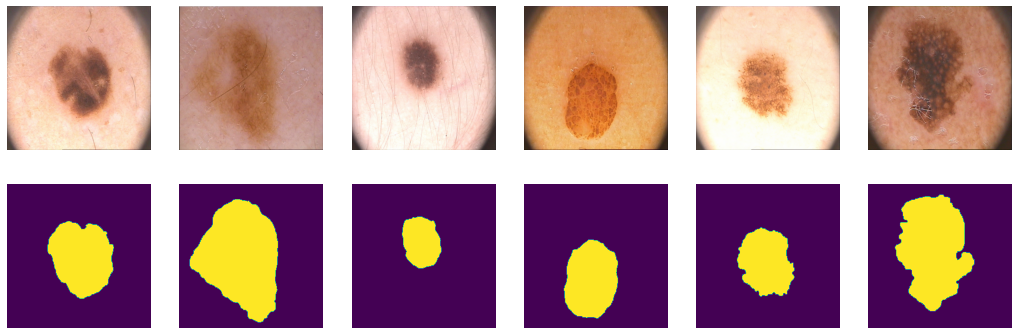

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

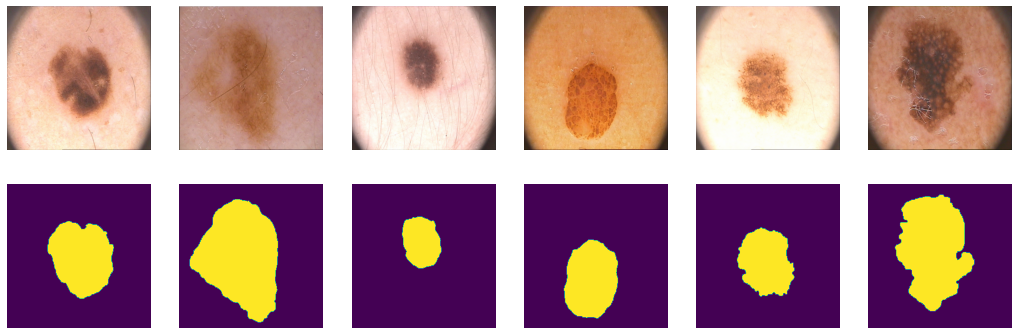

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
from torch.utils.data import Dataset

class DedyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return X.shape[0]
    
    def __getitem__(self, idx):
      image = self.X[idx]
      mask = self.Y[idx]

      return image, mask

In [ ]:
class WrapperDataset:
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.dataset[index]
        if self.transform is not None:
          transformed = transform(image = image, mask = mask)
          image = transformed['image']
          mask = transformed['mask']
           
        return np.rollaxis(image,2,0), mask[np.newaxis,]

    def __len__(self):
        return len(self.dataset)

In [ ]:
import albumentations as A
import cv2
import torch
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

In [ ]:
dset = DedyDataset(X,Y)
trainset = torch.utils.data.Subset(dset, tr)   
valset  = torch.utils.data.Subset(dset, val)                          
testset = torch.utils.data.Subset(dset, ts)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 8
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
loaders = {'train' : data_val, 'val' : data_val}

In [ ]:
from torch.utils.data import DataLoader
batch_size = 8
data_tr = DataLoader(WrapperDataset(trainset, transform), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(WrapperDataset(valset),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(WrapperDataset(testset),
                     batch_size=batch_size, shuffle=True)
loaders = {'train' : data_tr, 'val' : data_val}

Определим аугментацию наших данных

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

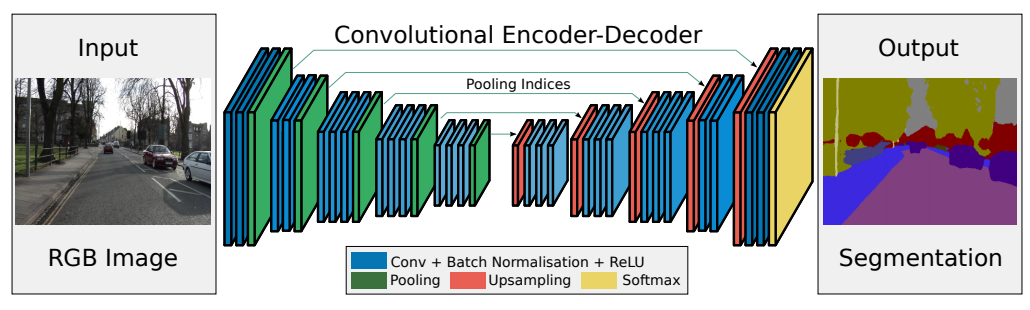

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
import torchvision

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(self.encoder_layer(3, 64), self.encoder_layer(64, 64))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(self.encoder_layer(64, 128), self.encoder_layer(128, 128))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(self.encoder_layer(128, 256), self.encoder_layer(256, 256), self.encoder_layer(256, 256))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(self.encoder_layer(256, 512), self.encoder_layer(512, 512), self.encoder_layer(512, 512))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16
        self.enc_conv4 = nn.Sequential(self.encoder_layer(512, 512), self.encoder_layer(512, 512),self.encoder_layer(512, 512)) 
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 16 -> 8



        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 8 -> 16
        self.dec_conv0 = nn.Sequential(self.decoder_layer(512, 512), self.decoder_layer(512, 512), self.decoder_layer(512, 512))
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv1 = nn.Sequential(self.decoder_layer(512, 512), self.decoder_layer(512, 512), self.decoder_layer(512, 256))
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(self.decoder_layer(256, 256), self.decoder_layer(256, 256), self.decoder_layer(256, 128))
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv3 = nn.Sequential(self.decoder_layer(128, 128), self.decoder_layer(128, 64))
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv4 = nn.Sequential(
            self.decoder_layer(64, 64),nn.Dropout(0.3),
            nn.Conv2d(64, 1, kernel_size=(3, 3), padding=(1, 1)))


    def encoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )
    
    def decoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )    

    def forward(self, x):
        # encoder
        x0, idx0 =  self.pool0(self.enc_conv0(x))
        x1, idx1 =  self.pool1(self.enc_conv1(x0))
        x2, idx2 =  self.pool2(self.enc_conv2(x1))
        x3, idx3 =  self.pool3(self.enc_conv3(x2))
        x4, idx4 =  self.pool4(self.enc_conv4(x3))

        # decoder
        d0 = self.dec_conv0(self.upsample0(x4, idx4))
        d1 = self.dec_conv1(self.upsample1(d0, idx3))
        d2 = self.dec_conv2(self.upsample2(d1, idx2))
        d3 = self.dec_conv3(self.upsample3(d2, idx1))
        d4 = self.dec_conv4(self.upsample4(d3, idx0))# no activation
        return d4

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean(y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его. Для удобства предусмотрим возможность отключения отображения исходных изображений и предсказанные нами маски, чтобы не засорять экран, ведь у нас будет обучаться много моделей. В процессе обучения мы будем сохранять модели с лучшими значениями функции потерь и на них оценивать нашу модель. Так же наша модель будет сохранять историю функции потерь и метрики в процессе обучения для последующего анализа.

In [ ]:
def draw_image(X_val,Y_hat, epoch, epochs, avg_loss, curr_score):
    for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
           
    plt.suptitle( '%d / %d - train_loss: %f , val_loss: %f, train_IoU: %f, val_IoU: %f' % (epoch+1, epochs, *avg_loss.values(), *curr_score.values()))
    plt.show()

def train(model, opt, loss_fn, sceduler, epochs, data_tr, data_val, drawimage = True, res_dict = None, phases = ['train', 'val']):#посмотреть что с валидацией, похоже он на нее тоже считает градиент
    X_val, Y_val = next(iter(data_val))
    best_model_wts = model.state_dict()
    if not res_dict:
        res_dict= {'losses' : {}, 'scores' : {}}
    losses, scores = {'train' : [], 'val' : []}, {'train' : [], 'val' : []}
    best_loss = np.inf
    for epoch in range(epochs):
        torch.cuda.empty_cache()
        tic = time()
        curr_score = {}
        avg_loss = {'train' : 0, 'val' : 0}
        for phase in phases:
          if phase == 'train':
              model.train()  # Set model to training mode
              scheduler.step()

          elif phase == 'val':
              model.eval()
          else:
            print('unknown')
          for X_batch, Y_batch in data_tr[phase]:
              # data to device
              # set parameter gradients to zero
              opt.zero_grad()
              # forward
              with torch.set_grad_enabled(phase == 'train'):
 #               print(phase, 'torch.set_grad_enable')
                output = model(X_batch.cuda())
                loss =  loss_fn(Y_batch.squeeze(1).cuda(), output.squeeze(1))# forward-pass
  #              print(phase, loss.requires_grad,'phase, loss.requires_grad')
                if phase == 'train':
   #                 print(phase, 'loss.backword')
                    loss.backward()  # backward-pass
                    opt.step()  # update weights

              # calculate loss to show the user
              avg_loss[phase] += loss / len(data_tr[phase])
              
              
          toc = time()
          #print('loss: %f' % avg_loss, sep = ' ')
          losses[phase].append(avg_loss[phase].item())
          curr_score[phase] = score_model(model, iou_pytorch, data_tr[phase])
          scores[phase].append(curr_score[phase])
        if avg_loss[phase] < best_loss and phase == 'val':
            print('upgrate best model on epoch %d' %(epoch+1))
            best_loss = avg_loss['val']
            best_model_wts = model.state_dict()
    

        # show intermediate results
        model.eval()  # testing mode
        Y_pred = model(X_val.cuda())
        Y_hat = (Y_pred > torch.tensor(0).cuda()).byte().detach().to('cpu')# detach and put into cpu
        if drawimage:
            draw_image(X_val,Y_hat, epoch, epochs, avg_loss, curr_score)
        else:
            print('%d / %d - train_loss: %f , val_loss: %f, train_IoU: %f, val_IoU: %f' % (epoch+1, epochs, *avg_loss.values(), *curr_score.values()))
        


        if loss_fn.__name__ in res_dict['losses'].keys():
                res_dict['losses'][loss_fn.__name__].update({type(model).__name__ : losses})
                res_dict['scores'][loss_fn.__name__].update( {type(model).__name__ : scores})
           
        else:
            res_dict['scores'].update({loss_fn.__name__ :  {type(model).__name__ : scores}})
            res_dict['losses'].update({loss_fn.__name__ : {type(model).__name__ : losses}})

    torch.save(best_model_wts, './weight.pt')
    model.load_state_dict(best_model_wts)

    return model, res_dict

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    with torch.no_grad():
        Y_pred = [model(X_batch) for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data, threshold = 0):
    model.eval()  # testing mode
    scores = 0
    threshold = torch.tensor(threshold).to(device)
    for X_batch, Y_label in data:
        with torch.no_grad():
            Y_pred = model(X_batch.to(device))

        scores += metric((Y_pred > threshold), Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f60e1d2f350>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f6101491110>}

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
from torch.optim import lr_scheduler

segnet_bce_model = SegNet().to(device)
max_epochs = 40
lr = 1e-4
optimizer = torch.optim.AdamW(segnet_bce_model.parameters(), lr = lr, weight_decay = 0.05)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
segnet_bce_model, res_dict = train(segnet_bce_model, optimizer, bce_loss, scheduler, max_epochs, loaders, data_val, drawimage = False)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


upgrate best model on epoch 1
1 / 40 - train_loss: 0.650800 , val_loss: 0.679996, train_IoU: 0.000000, val_IoU: 0.000000
upgrate best model on epoch 2
2 / 40 - train_loss: 0.496891 , val_loss: 0.646110, train_IoU: 0.000000, val_IoU: 0.000000
upgrate best model on epoch 3
3 / 40 - train_loss: 0.381564 , val_loss: 0.496408, train_IoU: 0.173077, val_IoU: 0.164286
upgrate best model on epoch 4
4 / 40 - train_loss: 0.353908 , val_loss: 0.405950, train_IoU: 0.169231, val_IoU: 0.212500
upgrate best model on epoch 5
5 / 40 - train_loss: 0.290731 , val_loss: 0.259063, train_IoU: 0.618269, val_IoU: 0.596429
6 / 40 - train_loss: 0.263384 , val_loss: 0.265527, train_IoU: 0.650962, val_IoU: 0.607143
7 / 40 - train_loss: 0.266062 , val_loss: 0.331211, train_IoU: 0.562500, val_IoU: 0.546429
8 / 40 - train_loss: 0.246966 , val_loss: 0.263369, train_IoU: 0.658654, val_IoU: 0.603571
upgrate best model on epoch 9
9 / 40 - train_loss: 0.258483 , val_loss: 0.228355, train_IoU: 0.720192, val_IoU: 0.660714
u

In [ ]:
model = SegNet().to(device)
model.load_state_dict(torch.load('/content/weight.pt'))
test_score = {}
test_score['segnet_bce'] = score_model(model, iou_pytorch, data_ts)
test_score['segnet_bce']

0.7642857262066433

Заведем словарь в котором мы будем хранить наши функции потерь и оценки для дальнейшего сравнения

In [ ]:
import seaborn as sns
def draw_losses(losses, scores, loss_name = 'bce_loss'):
    losses = losses
    metrics = scores

    sns.set(style="whitegrid", font_scale=1.4)

    # Построим график лосса при обучении и валидации
\
    #Ваш код здесь
    fig, ax = plt.subplots(2,2, figsize = (15,7), sharex = True)
    plt.tight_layout()
    for i, phase in enumerate(['train', 'val']):
      ax[i,0].plot(losses[phase])
      ax[i,1].plot(metrics[phase])
      ax[i,0].set_title(loss_name)
      ax[i,1].set_title('IoU')
      ax[i,0].set_xlabel('num_epochs', labelpad = 10)
      ax[i,1].set_xlabel('num_epochs', labelpad = 10)
    plt.figtext(0.5,0.95, "Training", ha="center", va="top", fontsize=20, color="r")
    plt.figtext(0.5,0.5, "Validation", ha="center", va="top", fontsize=20, color="r") 
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


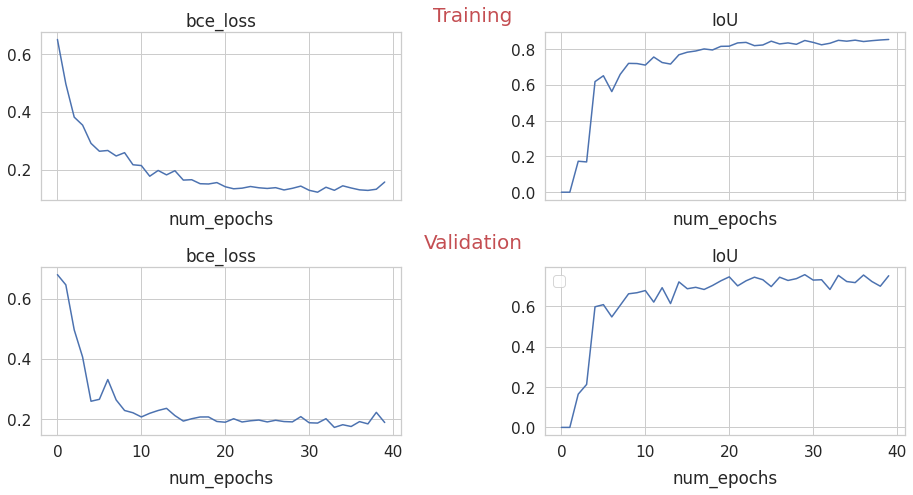

In [ ]:
draw_losses(res_dict['losses']['bce_loss']['SegNet'], res_dict['scores']['bce_loss']['SegNet'])

Ответьте себе на вопрос: не переобучается ли моя модель?

По данным loss переобучения модели не видно, модель выходит на плато и значения loss держатся примерно на одном уровне. Видно что нашей модели не хватает данных, направление производной не стабильно и сильно зависит от батча который попал на обучение

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)
    SMOOTH = 1e-8
    num = torch.sum(2*y_pred*y_real)
    den = torch.sum(y_pred+y_real)
    res = 1 - (1/(256*256))*(num + SMOOTH) / (den + SMOOTH)
    return res 

Проводим тестирование:

In [ ]:
from torch import optim
segnet_dice_model = SegNet().to(device)

max_epochs = 40
lr = 1e-4
optimizer = torch.optim.AdamW(segnet_dice_model.parameters(), lr = lr, weight_decay = 0.05)
segnet_dice_model, res_dict = train(segnet_dice_model, optimizer, dice_loss, scheduler, max_epochs, loaders, data_val, drawimage = False, res_dict = res_dict)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


upgrate best model on epoch 1
1 / 40 - train_loss: 0.999994 , val_loss: 0.999994, train_IoU: 0.000000, val_IoU: 0.000000
upgrate best model on epoch 2
2 / 40 - train_loss: 0.999993 , val_loss: 0.999994, train_IoU: 0.000000, val_IoU: 0.000000
3 / 40 - train_loss: 0.999992 , val_loss: 0.999994, train_IoU: 0.000000, val_IoU: 0.000000
upgrate best model on epoch 4
4 / 40 - train_loss: 0.999991 , val_loss: 0.999991, train_IoU: 0.433654, val_IoU: 0.453571
upgrate best model on epoch 5
5 / 40 - train_loss: 0.999990 , val_loss: 0.999990, train_IoU: 0.525962, val_IoU: 0.557143
6 / 40 - train_loss: 0.999990 , val_loss: 0.999990, train_IoU: 0.592308, val_IoU: 0.553571
upgrate best model on epoch 7
7 / 40 - train_loss: 0.999990 , val_loss: 0.999989, train_IoU: 0.535577, val_IoU: 0.485714
8 / 40 - train_loss: 0.999989 , val_loss: 0.999989, train_IoU: 0.654808, val_IoU: 0.608929
upgrate best model on epoch 9
9 / 40 - train_loss: 0.999988 , val_loss: 0.999988, train_IoU: 0.542308, val_IoU: 0.458929
u

In [ ]:
test_score['segnet_dice'] = score_model(segnet_dice_model, iou_pytorch, data_ts)
test_score['segnet_dice']

0.6517857142857143

No handles with labels found to put in legend.


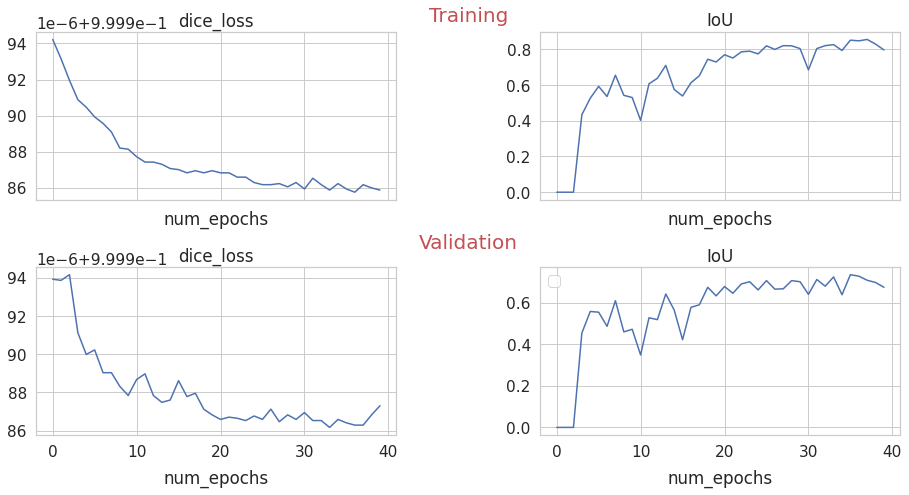

In [ ]:
draw_losses(res_dict['losses']['dice_loss']['SegNet'], res_dict['scores']['dice_loss']['SegNet'], 'dice_loss')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, alpha = 1, gamma = 2):
    bce = bce_loss(y_real, y_pred)
    your_loss =  alpha*((1-torch.exp(-bce))**gamma)*bce
    return your_loss


In [ ]:
segnet_focal_model = SegNet().to(device)

max_epochs = 40
lr = 1e-4
optimizer = torch.optim.AdamW(segnet_focal_model.parameters(), lr = lr, weight_decay = 0.05)
segnet_focal_model, res_dict = train(segnet_focal_model, optimizer, focal_loss, scheduler, max_epochs, loaders, data_val, drawimage = False, res_dict = res_dict)

upgrate best model on epoch 1
1 / 40 - train_loss: 0.168162 , val_loss: 0.168059, train_IoU: 0.000000, val_IoU: 0.000000
upgrate best model on epoch 2
2 / 40 - train_loss: 0.075851 , val_loss: 0.150062, train_IoU: 0.000000, val_IoU: 0.000000
upgrate best model on epoch 3
3 / 40 - train_loss: 0.050171 , val_loss: 0.105224, train_IoU: 0.036538, val_IoU: 0.053571
upgrate best model on epoch 4
4 / 40 - train_loss: 0.030704 , val_loss: 0.033845, train_IoU: 0.462500, val_IoU: 0.473214
upgrate best model on epoch 5
5 / 40 - train_loss: 0.022558 , val_loss: 0.023693, train_IoU: 0.566346, val_IoU: 0.525000
upgrate best model on epoch 6
6 / 40 - train_loss: 0.027768 , val_loss: 0.017957, train_IoU: 0.656731, val_IoU: 0.587500
7 / 40 - train_loss: 0.017991 , val_loss: 0.024389, train_IoU: 0.527885, val_IoU: 0.485714
8 / 40 - train_loss: 0.016790 , val_loss: 0.035023, train_IoU: 0.492308, val_IoU: 0.517857
upgrate best model on epoch 9
9 / 40 - train_loss: 0.011910 , val_loss: 0.017172, train_IoU:

In [ ]:
test_score['segnet_focal'] = score_model(segnet_focal_model, iou_pytorch, data_ts)
test_score['segnet_focal']

0.7321428826877049

No handles with labels found to put in legend.


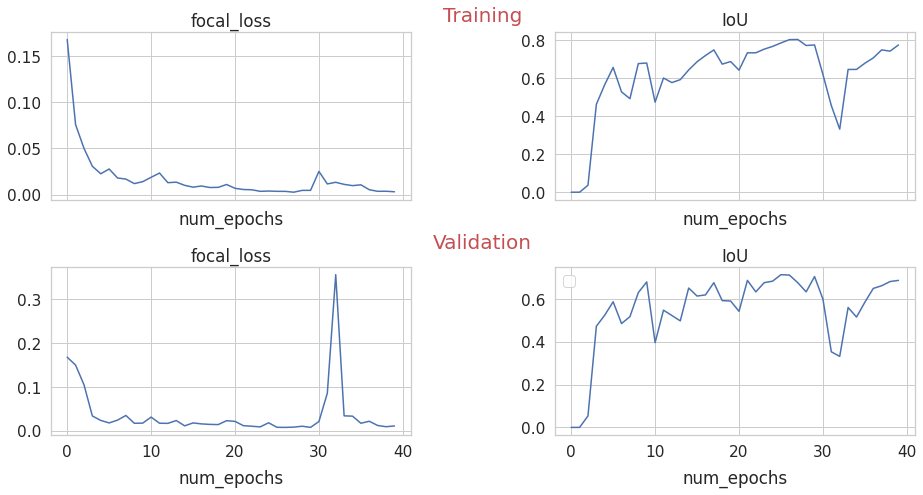

In [ ]:
draw_losses(res_dict['losses']['focal_loss']['SegNet'], res_dict['scores']['focal_loss']['SegNet'], 'focal_loss')

In [ ]:
def lovas_loss(labels: torch.Tensor,outputs: torch.Tensor):
        #outputs = torch.sigmoid(outputs)
        outputs = outputs.flatten()
        labels = labels.flatten()
        signs = 2 * labels.float() - 1
        errors = (1 - outputs * signs)
        errors_sorted, indices = torch.sort(errors, dim=0, descending=True)
        gt_sorted = labels[indices.data]

        # gradient
        gts = gt_sorted.sum()
        intersection = gts - gt_sorted.float().cumsum(0)
        union = gts + (1 - gt_sorted).float().cumsum(0)
        grad = 1. - intersection / union

        p = len(gt_sorted)
        grad[1:p] = grad[1:p] - grad[0:-1]
       
        loss = torch.dot(torch.relu(errors_sorted), grad)
        return loss

In [ ]:
def tversky_loss(labels: torch.Tensor, outputs: torch.Tensor, alpha:int = 0.5, beta:int = 0.5):
    outputs = torch.sigmoid(outputs)
    pp = (labels * outputs).sum()
    den1 = alpha * ((1 - labels) * outputs).sum()
    den2 = beta * (labels * (1 - outputs)).sum()
    tl = 1 - (1 + pp) / (1 + pp + den1 + den2)
    return tl    

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
segnet_lovas_model = SegNet().to(device)

max_epochs = 40
lr = 1e-4

optimizer = torch.optim.AdamW(segnet_lovas_model.parameters(), lr = lr, weight_decay = 0.05)
segnet_lovas_model, res_dict = train(segnet_lovas_model, optimizer, lovas_loss, scheduler,max_epochs, loaders, data_val, drawimage = False, res_dict = res_dict)

upgrate best model on epoch 1
1 / 40 - train_loss: 1.179952 , val_loss: 1.011300, train_IoU: 0.073077, val_IoU: 0.091071
upgrate best model on epoch 2
2 / 40 - train_loss: 1.089644 , val_loss: 1.010833, train_IoU: 0.034615, val_IoU: 0.044643
upgrate best model on epoch 3
3 / 40 - train_loss: 1.014022 , val_loss: 0.986950, train_IoU: 0.058654, val_IoU: 0.078571
4 / 40 - train_loss: 0.985351 , val_loss: 1.170392, train_IoU: 0.081731, val_IoU: 0.107143
5 / 40 - train_loss: 0.980456 , val_loss: 1.075253, train_IoU: 0.065385, val_IoU: 0.103571
upgrate best model on epoch 6
6 / 40 - train_loss: 0.944540 , val_loss: 0.869635, train_IoU: 0.228846, val_IoU: 0.230357
7 / 40 - train_loss: 0.897353 , val_loss: 0.964929, train_IoU: 0.099038, val_IoU: 0.103571
8 / 40 - train_loss: 0.851864 , val_loss: 0.901601, train_IoU: 0.473077, val_IoU: 0.451786
upgrate best model on epoch 9
9 / 40 - train_loss: 0.863532 , val_loss: 0.799357, train_IoU: 0.474038, val_IoU: 0.487500
10 / 40 - train_loss: 0.756962 

No handles with labels found to put in legend.


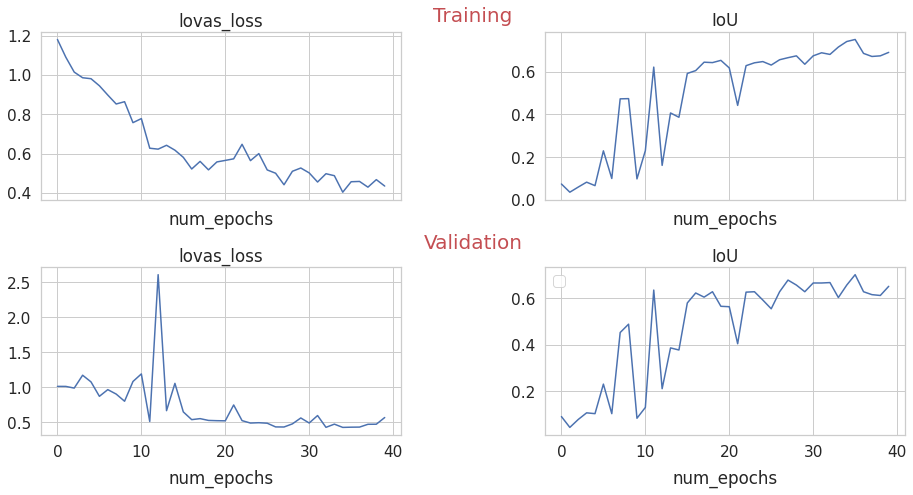

In [ ]:
draw_losses(res_dict['losses']['lovas_loss']['SegNet'], res_dict['scores']['lovas_loss']['SegNet'], 'lovas_loss')

In [ ]:
test_score['segnet_lovas'] = score_model(segnet_lovas_model, iou_pytorch, data_ts)
test_score['segnet_lovas']

0.6767857330186027

In [ ]:
segnet_tversky_model = SegNet().to(device)
max_epochs = 40
lr = 1e-4

optimizer = torch.optim.AdamW(segnet_tversky_model.parameters(), lr = lr, weight_decay = 0.05)
segnet_tversky_model, res_dict = train(segnet_tversky_model, optimizer, tversky_loss,scheduler,
                                       max_epochs, loaders, data_val, drawimage = False, res_dict = res_dict)

upgrate best model on epoch 1
1 / 40 - train_loss: 0.537222 , val_loss: 0.597727, train_IoU: 0.000000, val_IoU: 0.000000
2 / 40 - train_loss: 0.424146 , val_loss: 0.670736, train_IoU: 0.000000, val_IoU: 0.000000
upgrate best model on epoch 3
3 / 40 - train_loss: 0.341417 , val_loss: 0.441707, train_IoU: 0.295192, val_IoU: 0.333929
upgrate best model on epoch 4
4 / 40 - train_loss: 0.318998 , val_loss: 0.258456, train_IoU: 0.365385, val_IoU: 0.391071
5 / 40 - train_loss: 0.282426 , val_loss: 0.357923, train_IoU: 0.250000, val_IoU: 0.296429
6 / 40 - train_loss: 0.273122 , val_loss: 0.287695, train_IoU: 0.439423, val_IoU: 0.355357
7 / 40 - train_loss: 0.249791 , val_loss: 0.263980, train_IoU: 0.533654, val_IoU: 0.483929
upgrate best model on epoch 8
8 / 40 - train_loss: 0.232106 , val_loss: 0.236689, train_IoU: 0.550962, val_IoU: 0.462500
upgrate best model on epoch 9
9 / 40 - train_loss: 0.202599 , val_loss: 0.199144, train_IoU: 0.646154, val_IoU: 0.528571
10 / 40 - train_loss: 0.206269 

In [ ]:
test_score['segnet_tversky'] = score_model(segnet_tversky_model, iou_pytorch, data_ts)
test_score['segnet_tversky']

0.7625000136239188

No handles with labels found to put in legend.


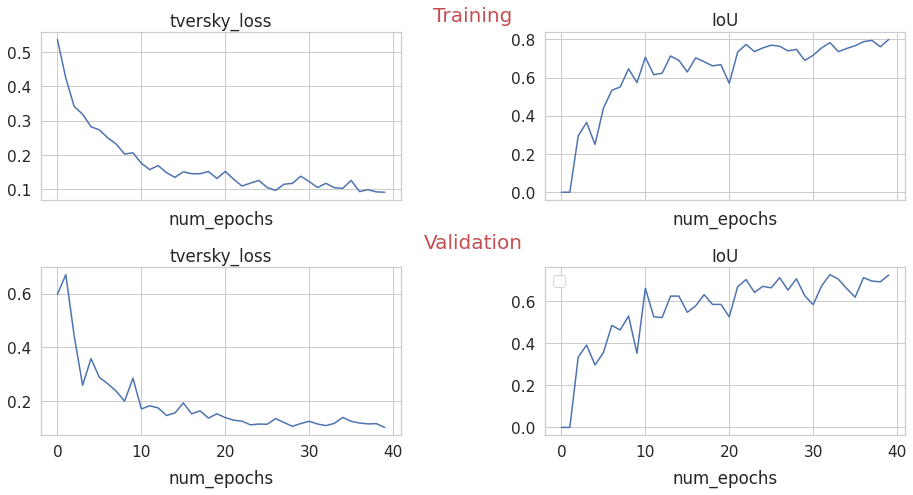

In [ ]:
draw_losses(res_dict['losses']['tversky_loss']['SegNet'], res_dict['scores']['tversky_loss']['SegNet'], 'tversky_loss')

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

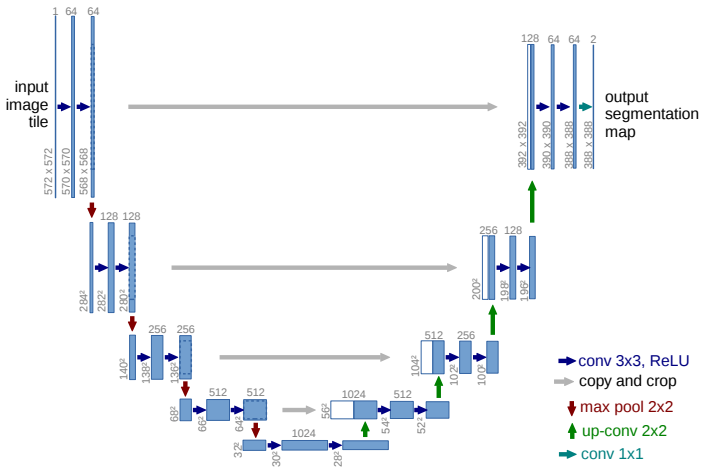

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(nn.Conv2d(3,64,3, padding = 1,),  nn.ReLU(), nn.BatchNorm2d(64),
                                       nn.Conv2d(64,64,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(64),)
        self.pool0 =   nn.MaxPool2d(3, 2, padding=1)
        self.enc_conv1 = nn.Sequential(nn.Conv2d(64,128,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(128),
                                       nn.Conv2d(128,128,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(128),)
        self.pool1 =  nn.MaxPool2d(3, 2, padding=1)
        self.enc_conv2 = nn.Sequential(nn.Conv2d(128,256,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(256),
                                       nn.Conv2d(256,256,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(256),)
        self.pool2 =  nn.MaxPool2d(3, 2, padding=1)
        self.enc_conv3 = nn.Sequential(nn.Conv2d(256,512,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(512),
                                       nn.Conv2d(512,512,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(512))
        self.pool3 =  nn.MaxPool2d(3, 2, padding=1)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(512,1024,3, padding = 1,), nn.ReLU(),nn.BatchNorm2d(1024), 
                                       nn.Conv2d(1024,512,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(512))
        self.upsample0 =  nn.Upsample(32)# 8 -> 16
        self.dec_conv0 =  nn.Sequential(nn.Conv2d(1024,512,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(512),
                                       nn.Conv2d(512,256,3, padding = 1,),nn.ReLU(),nn.BatchNorm2d(256),)
        self.upsample1 =  nn.Upsample(64)# 16 -> 32
        self.dec_conv1 = nn.Sequential(nn.Conv2d(512,256,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(256),
                                       nn.Conv2d(256,128,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(128),)
        self.upsample2 =  nn.Upsample(128)# 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(256,128,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(128),
                                       nn.Conv2d(128,64,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(64))
        self.upsample3 =  nn.Upsample(256)# 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(128,64,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(64),
                                       nn.Conv2d(64,64,3, padding = 1,), nn.ReLU(),nn.BatchNorm2d(64),#nn.Dropout(0.3), 
                                       nn.Conv2d(64,1,1))
        

    
    def forward(self, x):
        # encoder
        
        e0 = self.enc_conv0(x)
        x0 =  self.pool0(e0)
        e1 = self.enc_conv1(x0)
        x1 =  self.pool1(e1)                                
        e2 = self.enc_conv2(x1)
        x2 =  self.pool2(e2)
        e3 = self.enc_conv3(x2)
        x3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(x3)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b),e3),1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0),e2),1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1),e1),1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2),e0),1))
       # no activation
        return d3

In [ ]:
unet_bce_model = UNet().to(device)
max_epochs = 40
lr = 1e-4
unet_bce_model, res_dict =  train(unet_bce_model, optim.AdamW(unet_bce_model.parameters(), lr = lr, weight_decay = 0.05), bce_loss, scheduler, max_epochs, loaders, data_val, 
                                                   drawimage = False, res_dict = res_dict)

test_score['unet_bce'] = score_model(unet_bce_model, iou_pytorch, data_ts)

test_score['unet_bce']

upgrate best model on epoch 1
1 / 40 - train_loss: 0.442362 , val_loss: 0.657728, train_IoU: 0.041346, val_IoU: 0.069643
upgrate best model on epoch 2
2 / 40 - train_loss: 0.314180 , val_loss: 0.585896, train_IoU: 0.001923, val_IoU: 0.008929
upgrate best model on epoch 3
3 / 40 - train_loss: 0.293546 , val_loss: 0.571412, train_IoU: 0.039423, val_IoU: 0.053571
upgrate best model on epoch 4
4 / 40 - train_loss: 0.282644 , val_loss: 0.338515, train_IoU: 0.393269, val_IoU: 0.383929
5 / 40 - train_loss: 0.253216 , val_loss: 0.367070, train_IoU: 0.350962, val_IoU: 0.401786
upgrate best model on epoch 6
6 / 40 - train_loss: 0.248745 , val_loss: 0.293068, train_IoU: 0.638462, val_IoU: 0.557143
7 / 40 - train_loss: 0.247384 , val_loss: 0.321240, train_IoU: 0.689423, val_IoU: 0.623214
upgrate best model on epoch 8
8 / 40 - train_loss: 0.252691 , val_loss: 0.265281, train_IoU: 0.692308, val_IoU: 0.608929
upgrate best model on epoch 9
9 / 40 - train_loss: 0.256349 , val_loss: 0.251696, train_IoU:

0.7642857262066433

No handles with labels found to put in legend.


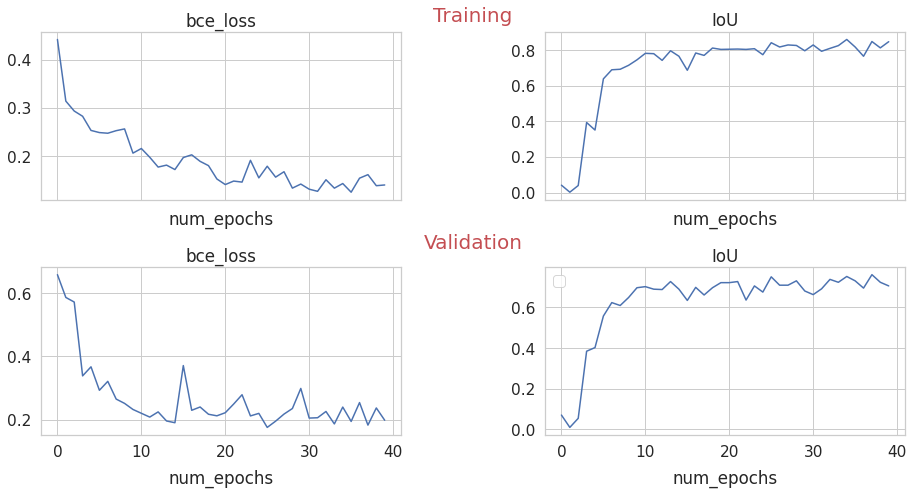

In [ ]:
draw_losses(res_dict['losses']['bce_loss']['UNet'], res_dict['scores']['bce_loss']['UNet'])

In [ ]:
unet_dice_model = UNet().to(device)
max_epochs = 40
lr = 1e-4
unet_dice_model, res_dict =  train(unet_dice_model, optim.AdamW(unet_dice_model.parameters(), lr = lr, weight_decay = 0.05), dice_loss,scheduler, max_epochs, loaders, data_val, 
                                   drawimage = False, res_dict = res_dict)

test_score['unet_dice'] = score_model(unet_dice_model, iou_pytorch, data_ts)
test_score['unet_dice']

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


upgrate best model on epoch 1
1 / 40 - train_loss: 0.999991 , val_loss: 0.999994, train_IoU: 0.125000, val_IoU: 0.121429
2 / 40 - train_loss: 0.999989 , val_loss: 0.999995, train_IoU: 0.004808, val_IoU: 0.021429
upgrate best model on epoch 3
3 / 40 - train_loss: 0.999989 , val_loss: 0.999993, train_IoU: 0.107692, val_IoU: 0.105357
upgrate best model on epoch 4
4 / 40 - train_loss: 0.999988 , val_loss: 0.999988, train_IoU: 0.603846, val_IoU: 0.607143
upgrate best model on epoch 5
5 / 40 - train_loss: 0.999988 , val_loss: 0.999988, train_IoU: 0.692308, val_IoU: 0.621429
6 / 40 - train_loss: 0.999988 , val_loss: 0.999988, train_IoU: 0.743269, val_IoU: 0.632143
7 / 40 - train_loss: 0.999987 , val_loss: 0.999988, train_IoU: 0.727885, val_IoU: 0.644643
upgrate best model on epoch 8
8 / 40 - train_loss: 0.999987 , val_loss: 0.999988, train_IoU: 0.768269, val_IoU: 0.676786
upgrate best model on epoch 9
9 / 40 - train_loss: 0.999987 , val_loss: 0.999987, train_IoU: 0.750962, val_IoU: 0.619643
u

0.7803571564810616

No handles with labels found to put in legend.


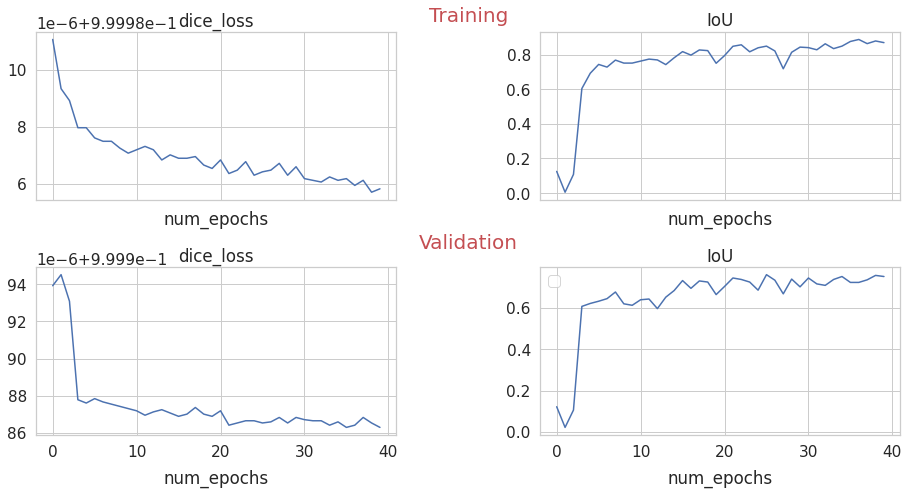

In [ ]:
draw_losses(res_dict['losses']['dice_loss']['UNet'], res_dict['scores']['dice_loss']['UNet'],'dice_loss')

In [ ]:
unet_focal_model = UNet().to(device)
max_epochs = 40
lr = 1e-4
unet_focal_model, res_dict =  train(unet_focal_model, optim.AdamW(unet_focal_model.parameters(),lr = lr, weight_decay = 0.05), focal_loss, scheduler, max_epochs, loaders, data_val, 
                                    drawimage = False, res_dict = res_dict)

test_score['unet_focal'] = score_model(unet_focal_model, iou_pytorch, data_ts)
test_score['unet_focal']

upgrate best model on epoch 1
1 / 40 - train_loss: 0.056941 , val_loss: 0.149005, train_IoU: 0.000000, val_IoU: 0.000000
upgrate best model on epoch 2
2 / 40 - train_loss: 0.023450 , val_loss: 0.130310, train_IoU: 0.000000, val_IoU: 0.000000
upgrate best model on epoch 3
3 / 40 - train_loss: 0.019137 , val_loss: 0.086634, train_IoU: 0.114423, val_IoU: 0.108929
upgrate best model on epoch 4
4 / 40 - train_loss: 0.016027 , val_loss: 0.027709, train_IoU: 0.505769, val_IoU: 0.535714
upgrate best model on epoch 5
5 / 40 - train_loss: 0.016607 , val_loss: 0.020948, train_IoU: 0.596154, val_IoU: 0.598214
upgrate best model on epoch 6
6 / 40 - train_loss: 0.017296 , val_loss: 0.015581, train_IoU: 0.623077, val_IoU: 0.592857
7 / 40 - train_loss: 0.014094 , val_loss: 0.023881, train_IoU: 0.600000, val_IoU: 0.601786
8 / 40 - train_loss: 0.013487 , val_loss: 0.021168, train_IoU: 0.664423, val_IoU: 0.619643
9 / 40 - train_loss: 0.014572 , val_loss: 0.018057, train_IoU: 0.679808, val_IoU: 0.555357
u

0.6464285807950156

No handles with labels found to put in legend.


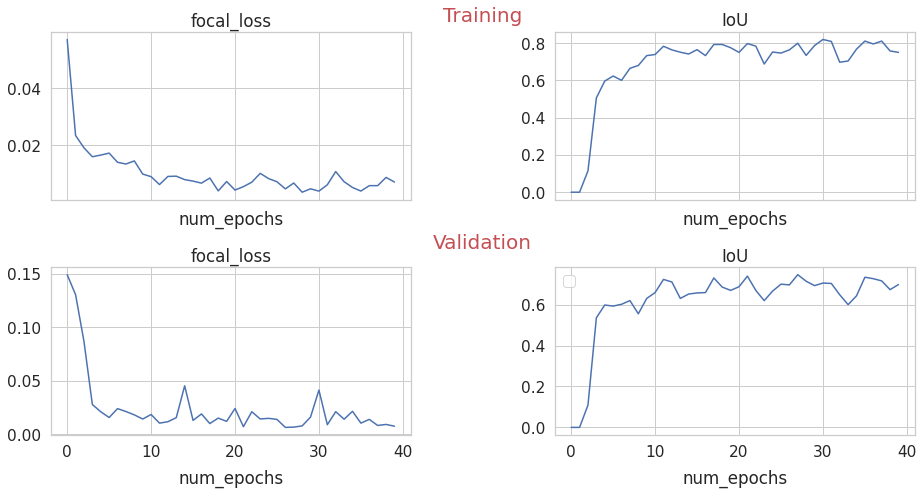

In [ ]:
draw_losses(res_dict['losses']['focal_loss']['UNet'], res_dict['scores']['focal_loss']['UNet'],'focal_loss')

In [ ]:
unet_lovas_model = UNet().to(device)
max_epochs = 40
lr = 1e-4
unet_lovas_model, res_dict =  train(unet_lovas_model, optim.AdamW(unet_lovas_model.parameters(), lr = lr, weight_decay = 0.05), lovas_loss, scheduler, max_epochs, loaders, data_val, 
                                                   drawimage = False, res_dict = res_dict)

test_score['unet_lovas'] = score_model(unet_lovas_model, iou_pytorch, data_ts)
test_score['unet_lovas']

upgrate best model on epoch 1
1 / 40 - train_loss: 0.897702 , val_loss: 1.022710, train_IoU: 0.012500, val_IoU: 0.026786
2 / 40 - train_loss: 0.711873 , val_loss: 1.304615, train_IoU: 0.000000, val_IoU: 0.008929
3 / 40 - train_loss: 0.559227 , val_loss: 1.057026, train_IoU: 0.181731, val_IoU: 0.173214
upgrate best model on epoch 4
4 / 40 - train_loss: 0.564516 , val_loss: 0.661713, train_IoU: 0.396154, val_IoU: 0.401786
upgrate best model on epoch 5
5 / 40 - train_loss: 0.559054 , val_loss: 0.595409, train_IoU: 0.466346, val_IoU: 0.516071
6 / 40 - train_loss: 0.519859 , val_loss: 0.628295, train_IoU: 0.659615, val_IoU: 0.633929
upgrate best model on epoch 7
7 / 40 - train_loss: 0.494276 , val_loss: 0.490041, train_IoU: 0.705769, val_IoU: 0.637500
8 / 40 - train_loss: 0.498345 , val_loss: 0.541662, train_IoU: 0.738462, val_IoU: 0.653571
upgrate best model on epoch 9
9 / 40 - train_loss: 0.504695 , val_loss: 0.461802, train_IoU: 0.716346, val_IoU: 0.673214
upgrate best model on epoch 10


0.778571435383388

No handles with labels found to put in legend.


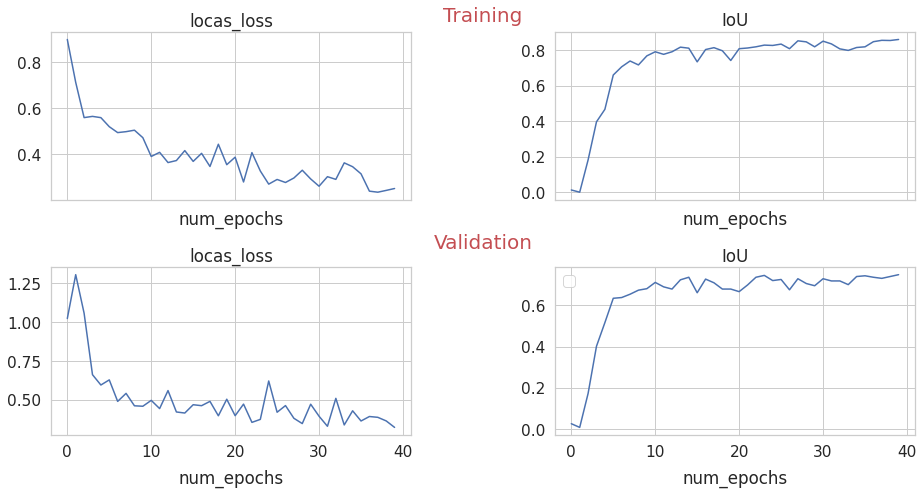

In [ ]:
draw_losses(res_dict['losses']['lovas_loss']['UNet'], res_dict['scores']['lovas_loss']['UNet'], 'locas_loss')

In [ ]:
unet_tversky_model = UNet().to(device)
max_epochs = 40
lr = 1e-4
unet_tversky_model, res_dict =  train(unet_tversky_model, optim.AdamW(unet_tversky_model.parameters(),lr = lr, weight_decay = 0.05),
                                      tversky_loss,scheduler, max_epochs, loaders, data_val, 
                                    drawimage = False, res_dict = res_dict)

test_score['unet_tversky'] = score_model(unet_tversky_model, iou_pytorch, data_ts)
test_score['unet_tversky']

upgrate best model on epoch 1
1 / 40 - train_loss: 0.383215 , val_loss: 0.602063, train_IoU: 0.022115, val_IoU: 0.050000
2 / 40 - train_loss: 0.264493 , val_loss: 0.770757, train_IoU: 0.000000, val_IoU: 0.000000
3 / 40 - train_loss: 0.230783 , val_loss: 0.871528, train_IoU: 0.004808, val_IoU: 0.005357
upgrate best model on epoch 4
4 / 40 - train_loss: 0.192529 , val_loss: 0.202113, train_IoU: 0.369231, val_IoU: 0.392857
upgrate best model on epoch 5
5 / 40 - train_loss: 0.170666 , val_loss: 0.180724, train_IoU: 0.572115, val_IoU: 0.510714
upgrate best model on epoch 6
6 / 40 - train_loss: 0.172699 , val_loss: 0.159880, train_IoU: 0.668269, val_IoU: 0.628571
7 / 40 - train_loss: 0.162205 , val_loss: 0.179409, train_IoU: 0.634615, val_IoU: 0.601786
upgrate best model on epoch 8
8 / 40 - train_loss: 0.142569 , val_loss: 0.140956, train_IoU: 0.671154, val_IoU: 0.619643
9 / 40 - train_loss: 0.166200 , val_loss: 0.163001, train_IoU: 0.678846, val_IoU: 0.591071
10 / 40 - train_loss: 0.144772 

0.7767857313156128

No handles with labels found to put in legend.


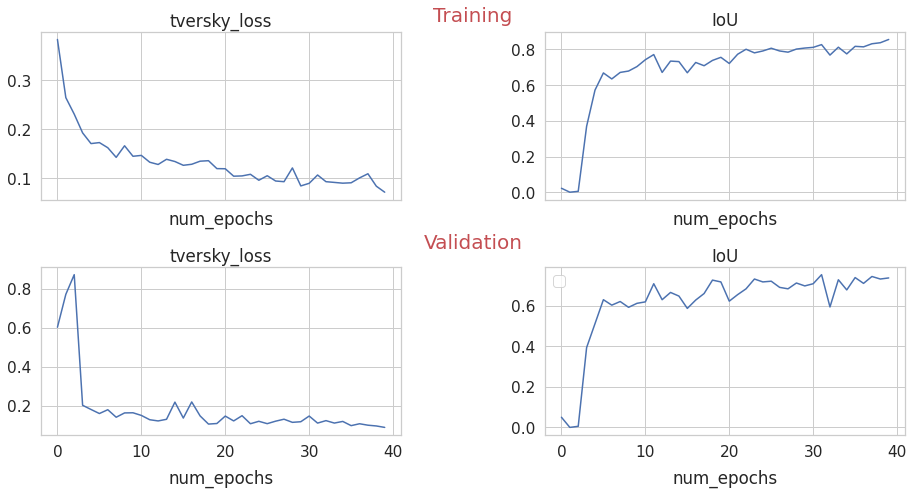

In [ ]:
draw_losses(res_dict['losses']['tversky_loss']['UNet'], res_dict['scores']['tversky_loss']['UNet'], 'tversky_loss')

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0_1 = nn.Sequential(nn.Conv2d(3,64,3, padding = 1),  nn.ReLU(), nn.BatchNorm2d(64),
                                        nn.Conv2d(64,64,3, padding = 1),  nn.ReLU(), nn.BatchNorm2d(64))
        self.enc_conv0_2 = nn.Sequential(nn.Conv2d(64,64,3, stride = 2,padding = 1),  nn.ReLU(), nn.BatchNorm2d(64))
        self.enc_conv1_1 = nn.Sequential(nn.Conv2d(64,128,3, padding = 1),  nn.ReLU(), nn.BatchNorm2d(128),
                                        nn.Conv2d(128,128,3,padding = 1),  nn.ReLU(), nn.BatchNorm2d(128))
        self.enc_conv1_2 = nn.Sequential(nn.Conv2d(128,128,3, stride = 2,padding = 1),  nn.ReLU(), nn.BatchNorm2d(128))
        self.enc_conv2_1 = nn.Sequential(nn.Conv2d(128,256,3, padding = 1),  nn.ReLU(), nn.BatchNorm2d(256),
                                        nn.Conv2d(256,256,3, padding = 1),  nn.ReLU(), nn.BatchNorm2d(256))
        self.enc_conv2_2 = nn.Sequential(nn.Conv2d(256,256,3, stride = 2,padding = 1),  nn.ReLU(), nn.BatchNorm2d(256))
        self.enc_conv3_1 = nn.Sequential(nn.Conv2d(256,512,3, padding = 1),  nn.ReLU(), nn.BatchNorm2d(512),
                                        nn.Conv2d(512,512,3, padding = 1),  nn.ReLU(), nn.BatchNorm2d(512))
        self.enc_conv3_2 = nn.Sequential(nn.Conv2d(512,512,3, stride = 2,padding = 1),  nn.ReLU(), nn.BatchNorm2d(512))



        # bottleneck
        self.bottleneck= nn.Sequential(nn.Conv2d(512,1024,3, padding = 1,), nn.ReLU(),nn.BatchNorm2d(1024), 
                                       nn.Conv2d(1024,512,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(512))
        self.upsample0 =  nn.Sequential(nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 2, stride = 2),nn.ReLU(),nn.BatchNorm2d(512))
        self.dec_conv0 =  nn.Sequential(nn.Conv2d(1024,512,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(512),
                                       nn.Conv2d(512,256,3, padding = 1,),nn.ReLU(),nn.BatchNorm2d(256),)
        self.upsample1 =  nn.Sequential(nn.ConvTranspose2d(in_channels = 256, out_channels = 256,kernel_size = 2, stride = 2),nn.ReLU(),nn.BatchNorm2d(256))
        self.dec_conv1 = nn.Sequential(nn.Conv2d(512,256,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(256),
                                       nn.Conv2d(256,128,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(128),)
        self.upsample2 =  nn.Sequential(nn.ConvTranspose2d(in_channels = 128, out_channels = 128, kernel_size = 2,stride = 2),nn.ReLU(),nn.BatchNorm2d(128))
        self.dec_conv2 = nn.Sequential(nn.Conv2d(256,128,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(128),
                                       nn.Conv2d(128,64,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(64))
        self.upsample3 =  nn.Sequential(nn.ConvTranspose2d(in_channels = 64, out_channels = 64,kernel_size = 2, stride = 2),nn.ReLU(),nn.BatchNorm2d(64))
        self.dec_conv3 = nn.Sequential(nn.Conv2d(128,64,3, padding = 1,), nn.ReLU(), nn.BatchNorm2d(64),
                                       nn.Conv2d(64,64,3, padding = 1,), nn.ReLU(),nn.BatchNorm2d(64)) #nn.Dropout(0.3))
        self.conv_final = nn.Conv2d(in_channels=64, out_channels=1,
                                    kernel_size=1, padding=0, stride=1)

    def forward(self, x):
        # encoder
        
        e0 = self.enc_conv0_1(x)
        x = self.enc_conv0_2(e0)
        e1 = self.enc_conv1_1(x)
        x = self.enc_conv1_2(e1)
        e2 = self.enc_conv2_1(x)
        x = self.enc_conv2_2(e2)
        e3 = self.enc_conv3_1(x)
        x = self.enc_conv3_2(e3)
        
        # bottleneck
        b = self.bottleneck(x)
        

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b),e3),1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0),e2),1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1),e1),1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2),e0),1))
        d4 = self.conv_final(d3)
       # no activation
        return d4


In [ ]:
unet2_bce_model = UNet2().to(device)
max_epochs = 40
lr = 1e-4
unet2_bce_model, res_dict =  train(unet2_bce_model, optim.AdamW(unet2_bce_model.parameters(), lr = lr,  weight_decay = 0.05), bce_loss, scheduler, max_epochs, loaders, data_val, 
                                    drawimage = False, res_dict=res_dict)
test_score['unet2_bce'] = score_model(unet2_bce_model, iou_pytorch, data_ts)
test_score['unet2_bce']

upgrate best model on epoch 1
1 / 40 - train_loss: 0.510410 , val_loss: 0.674693, train_IoU: 0.159615, val_IoU: 0.148214
upgrate best model on epoch 2
2 / 40 - train_loss: 0.357885 , val_loss: 0.556297, train_IoU: 0.102885, val_IoU: 0.101786
upgrate best model on epoch 3
3 / 40 - train_loss: 0.316125 , val_loss: 0.402220, train_IoU: 0.414423, val_IoU: 0.435714
4 / 40 - train_loss: 0.278730 , val_loss: 0.471106, train_IoU: 0.377885, val_IoU: 0.353571
upgrate best model on epoch 5
5 / 40 - train_loss: 0.283234 , val_loss: 0.319213, train_IoU: 0.540385, val_IoU: 0.566071
6 / 40 - train_loss: 0.331389 , val_loss: 0.369633, train_IoU: 0.539423, val_IoU: 0.439286
upgrate best model on epoch 7
7 / 40 - train_loss: 0.266795 , val_loss: 0.262350, train_IoU: 0.647115, val_IoU: 0.575000
8 / 40 - train_loss: 0.242989 , val_loss: 0.290361, train_IoU: 0.641346, val_IoU: 0.548214
upgrate best model on epoch 9
9 / 40 - train_loss: 0.247944 , val_loss: 0.257892, train_IoU: 0.695192, val_IoU: 0.626786
1

0.7410714541162763

No handles with labels found to put in legend.


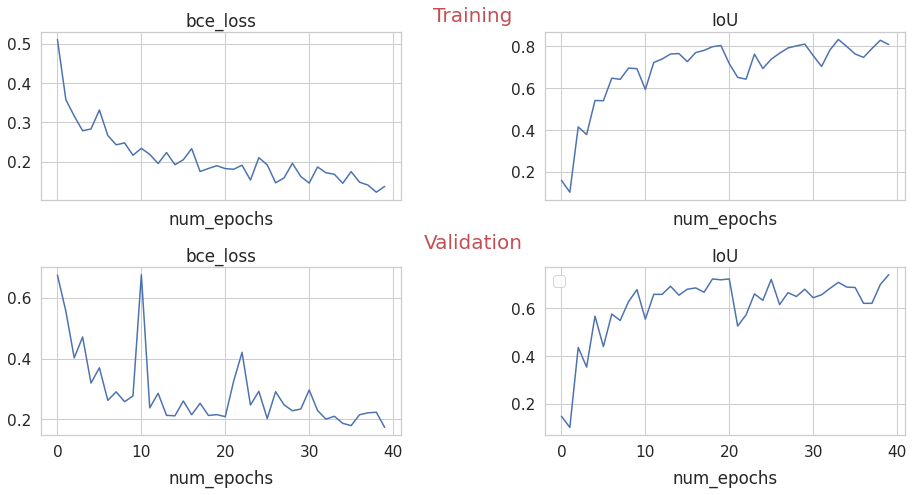

In [ ]:
draw_losses(res_dict['losses']['bce_loss']['UNet2'], res_dict['scores']['bce_loss']['UNet2'])

In [ ]:
unet2_dice_model = UNet2().to(device)
max_epochs = 40
lr = 1e-4
unet2_dice_model, res_dict =  train(unet2_dice_model, optim.AdamW(unet2_dice_model.parameters(), lr = lr, weight_decay = 0.05),
                                    dice_loss,scheduler, max_epochs, loaders, data_val,
                                    res_dict = res_dict, drawimage = False)
test_score['unet2_dice'] = score_model(unet2_dice_model, iou_pytorch, data_ts)
test_score['unet2_dice']

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


upgrate best model on epoch 1
1 / 40 - train_loss: 0.999992 , val_loss: 0.999994, train_IoU: 0.203846, val_IoU: 0.228571
upgrate best model on epoch 2
2 / 40 - train_loss: 0.999990 , val_loss: 0.999991, train_IoU: 0.175962, val_IoU: 0.176786
upgrate best model on epoch 3
3 / 40 - train_loss: 0.999989 , val_loss: 0.999990, train_IoU: 0.182692, val_IoU: 0.225000
upgrate best model on epoch 4
4 / 40 - train_loss: 0.999989 , val_loss: 0.999989, train_IoU: 0.288462, val_IoU: 0.301786
upgrate best model on epoch 5
5 / 40 - train_loss: 0.999989 , val_loss: 0.999989, train_IoU: 0.321154, val_IoU: 0.378571
upgrate best model on epoch 6
6 / 40 - train_loss: 0.999988 , val_loss: 0.999988, train_IoU: 0.570192, val_IoU: 0.558929
upgrate best model on epoch 7
7 / 40 - train_loss: 0.999988 , val_loss: 0.999988, train_IoU: 0.555769, val_IoU: 0.512500
8 / 40 - train_loss: 0.999988 , val_loss: 0.999988, train_IoU: 0.613462, val_IoU: 0.583929
upgrate best model on epoch 9
9 / 40 - train_loss: 0.999988 , 

0.7517857296126229

No handles with labels found to put in legend.


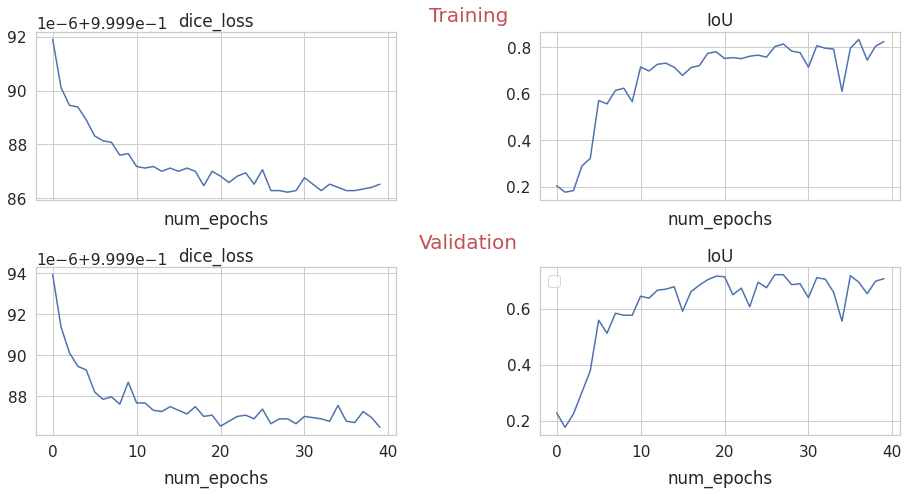

In [ ]:
draw_losses(res_dict['losses']['dice_loss']['UNet2'], res_dict['scores']['dice_loss']['UNet2'], 'dice_loss')

In [ ]:
unet2_focal_model = UNet2().to(device)
max_epochs = 40
lr = 1e-4
unet2_focal_model, res_dict =  train(unet2_focal_model, optim.AdamW(unet2_focal_model.parameters(), lr = lr,  
                                                                    weight_decay = 0.05),
                                     focal_loss, scheduler, max_epochs, loaders, data_val, 
                                     res_dict = res_dict, drawimage = False)
test_score['unet2_focal'] = score_model(unet2_focal_model, iou_pytorch, data_ts)
test_score['unet2_focal']

upgrate best model on epoch 1
1 / 40 - train_loss: 0.075670 , val_loss: 0.155252, train_IoU: 0.000000, val_IoU: 0.000000
upgrate best model on epoch 2
2 / 40 - train_loss: 0.025828 , val_loss: 0.115296, train_IoU: 0.000000, val_IoU: 0.001786
upgrate best model on epoch 3
3 / 40 - train_loss: 0.030677 , val_loss: 0.058314, train_IoU: 0.196154, val_IoU: 0.169643
upgrate best model on epoch 4
4 / 40 - train_loss: 0.019083 , val_loss: 0.028409, train_IoU: 0.414423, val_IoU: 0.433929
5 / 40 - train_loss: 0.021204 , val_loss: 0.072199, train_IoU: 0.349038, val_IoU: 0.332143
6 / 40 - train_loss: 0.016349 , val_loss: 0.076669, train_IoU: 0.504808, val_IoU: 0.498214
7 / 40 - train_loss: 0.015963 , val_loss: 0.031887, train_IoU: 0.648077, val_IoU: 0.585714
upgrate best model on epoch 8
8 / 40 - train_loss: 0.019035 , val_loss: 0.019760, train_IoU: 0.617308, val_IoU: 0.576786
9 / 40 - train_loss: 0.017689 , val_loss: 0.023496, train_IoU: 0.637500, val_IoU: 0.535714
10 / 40 - train_loss: 0.013055 

0.7178571394511631

No handles with labels found to put in legend.


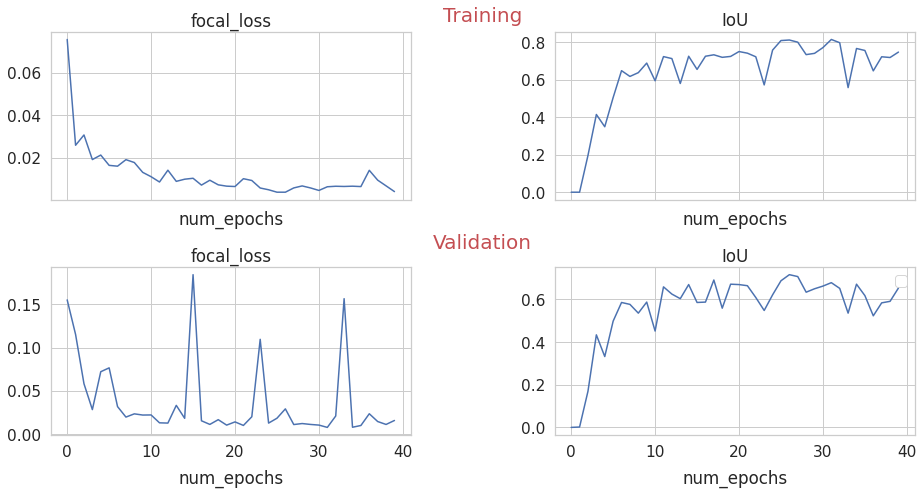

In [ ]:
draw_losses(res_dict['losses']['focal_loss']['UNet2'], res_dict['scores']['focal_loss']['UNet2'], 'focal_loss')

In [ ]:
unet2_lovas_model = UNet2().to(device)
max_epochs = 40
lr = 1e-4
unet2_lovas_model, res_dict =  train(unet2_lovas_model, optim.AdamW(unet2_lovas_model.parameters(), lr = lr,  
                                                                    weight_decay = 0.05),
                                     lovas_loss,scheduler, max_epochs, loaders, data_val, 
                                                   drawimage = False, res_dict = res_dict)

test_score['unet2_lovas'] = score_model(unet2_lovas_model, iou_pytorch, data_ts)
test_score['unet2_lovas']

upgrate best model on epoch 1
1 / 40 - train_loss: 0.908560 , val_loss: 1.200199, train_IoU: 0.000000, val_IoU: 0.000000
2 / 40 - train_loss: 0.770927 , val_loss: 1.250310, train_IoU: 0.008654, val_IoU: 0.021429
upgrate best model on epoch 3
3 / 40 - train_loss: 0.606065 , val_loss: 0.892599, train_IoU: 0.197115, val_IoU: 0.198214
upgrate best model on epoch 4
4 / 40 - train_loss: 0.575488 , val_loss: 0.691985, train_IoU: 0.442308, val_IoU: 0.435714
upgrate best model on epoch 5
5 / 40 - train_loss: 0.586210 , val_loss: 0.639234, train_IoU: 0.420192, val_IoU: 0.432143
upgrate best model on epoch 6
6 / 40 - train_loss: 0.591371 , val_loss: 0.631375, train_IoU: 0.556731, val_IoU: 0.537500
upgrate best model on epoch 7
7 / 40 - train_loss: 0.484018 , val_loss: 0.606409, train_IoU: 0.659615, val_IoU: 0.582143
8 / 40 - train_loss: 0.511591 , val_loss: 0.686685, train_IoU: 0.697115, val_IoU: 0.671429
9 / 40 - train_loss: 0.558301 , val_loss: 0.630611, train_IoU: 0.689423, val_IoU: 0.582143
u

0.7196428860936847

No handles with labels found to put in legend.


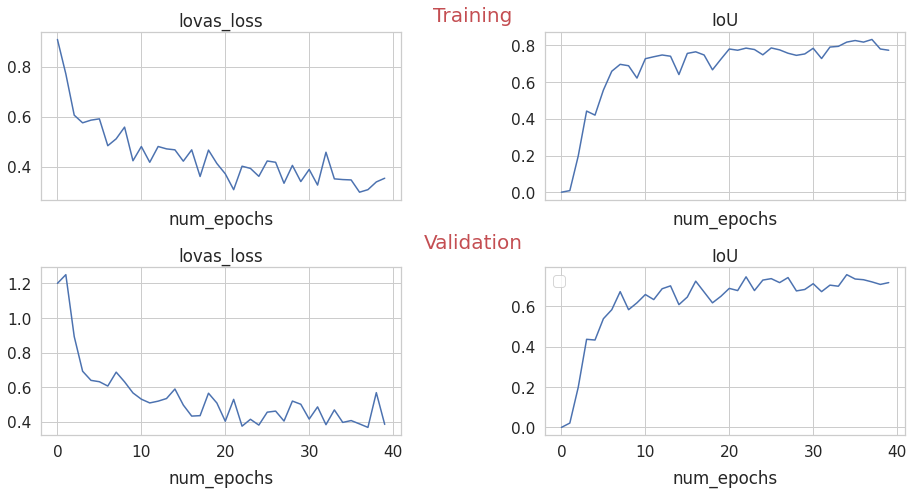

In [ ]:
draw_losses(res_dict['losses']['lovas_loss']['UNet2'], res_dict['scores']['lovas_loss']['UNet2'], 'lovas_loss')

In [ ]:
unet2_tversky_model = UNet2().to(device)
max_epochs = 40
lr = 1e-4
unet2_tversky_model, res_dict =  train(unet2_tversky_model, optim.AdamW(unet2_tversky_model.parameters(),lr = lr, 
                                                                        weight_decay = 0.05),
                                       tversky_loss,scheduler, max_epochs, loaders, data_val, 
                                    drawimage = False, res_dict = res_dict)

test_score['unet2_tversky'] = score_model(unet2_tversky_model, iou_pytorch, data_ts)
test_score['unet2_tversky']

upgrate best model on epoch 1
1 / 40 - train_loss: 0.442963 , val_loss: 0.563972, train_IoU: 0.122115, val_IoU: 0.173214
upgrate best model on epoch 2
2 / 40 - train_loss: 0.314410 , val_loss: 0.488916, train_IoU: 0.175000, val_IoU: 0.187500
upgrate best model on epoch 3
3 / 40 - train_loss: 0.249214 , val_loss: 0.265416, train_IoU: 0.320192, val_IoU: 0.360714
upgrate best model on epoch 4
4 / 40 - train_loss: 0.213556 , val_loss: 0.263923, train_IoU: 0.321154, val_IoU: 0.364286
upgrate best model on epoch 5
5 / 40 - train_loss: 0.221708 , val_loss: 0.242777, train_IoU: 0.362500, val_IoU: 0.366071
6 / 40 - train_loss: 0.201731 , val_loss: 0.285600, train_IoU: 0.404808, val_IoU: 0.410714
upgrate best model on epoch 7
7 / 40 - train_loss: 0.183226 , val_loss: 0.214604, train_IoU: 0.434615, val_IoU: 0.366071
8 / 40 - train_loss: 0.185563 , val_loss: 0.216973, train_IoU: 0.523077, val_IoU: 0.503571
upgrate best model on epoch 9
9 / 40 - train_loss: 0.187780 , val_loss: 0.174672, train_IoU:

0.7250000068119594

No handles with labels found to put in legend.


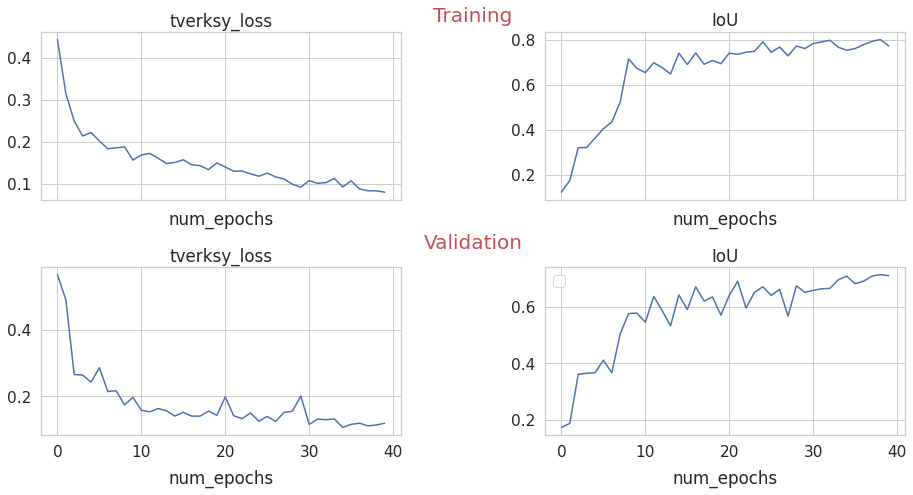

In [ ]:
draw_losses(res_dict['losses']['tversky_loss']['UNet2'], res_dict['scores']['tversky_loss']['UNet2'],'tverksy_loss')

In [ ]:
res_dict['losses']['bce_loss']['UNet'].keys()

dict_keys(['train', 'val'])

## Изменение loss и метрики IoU для каждой функции потери в процессе обучения модели на тренировочной выборке 

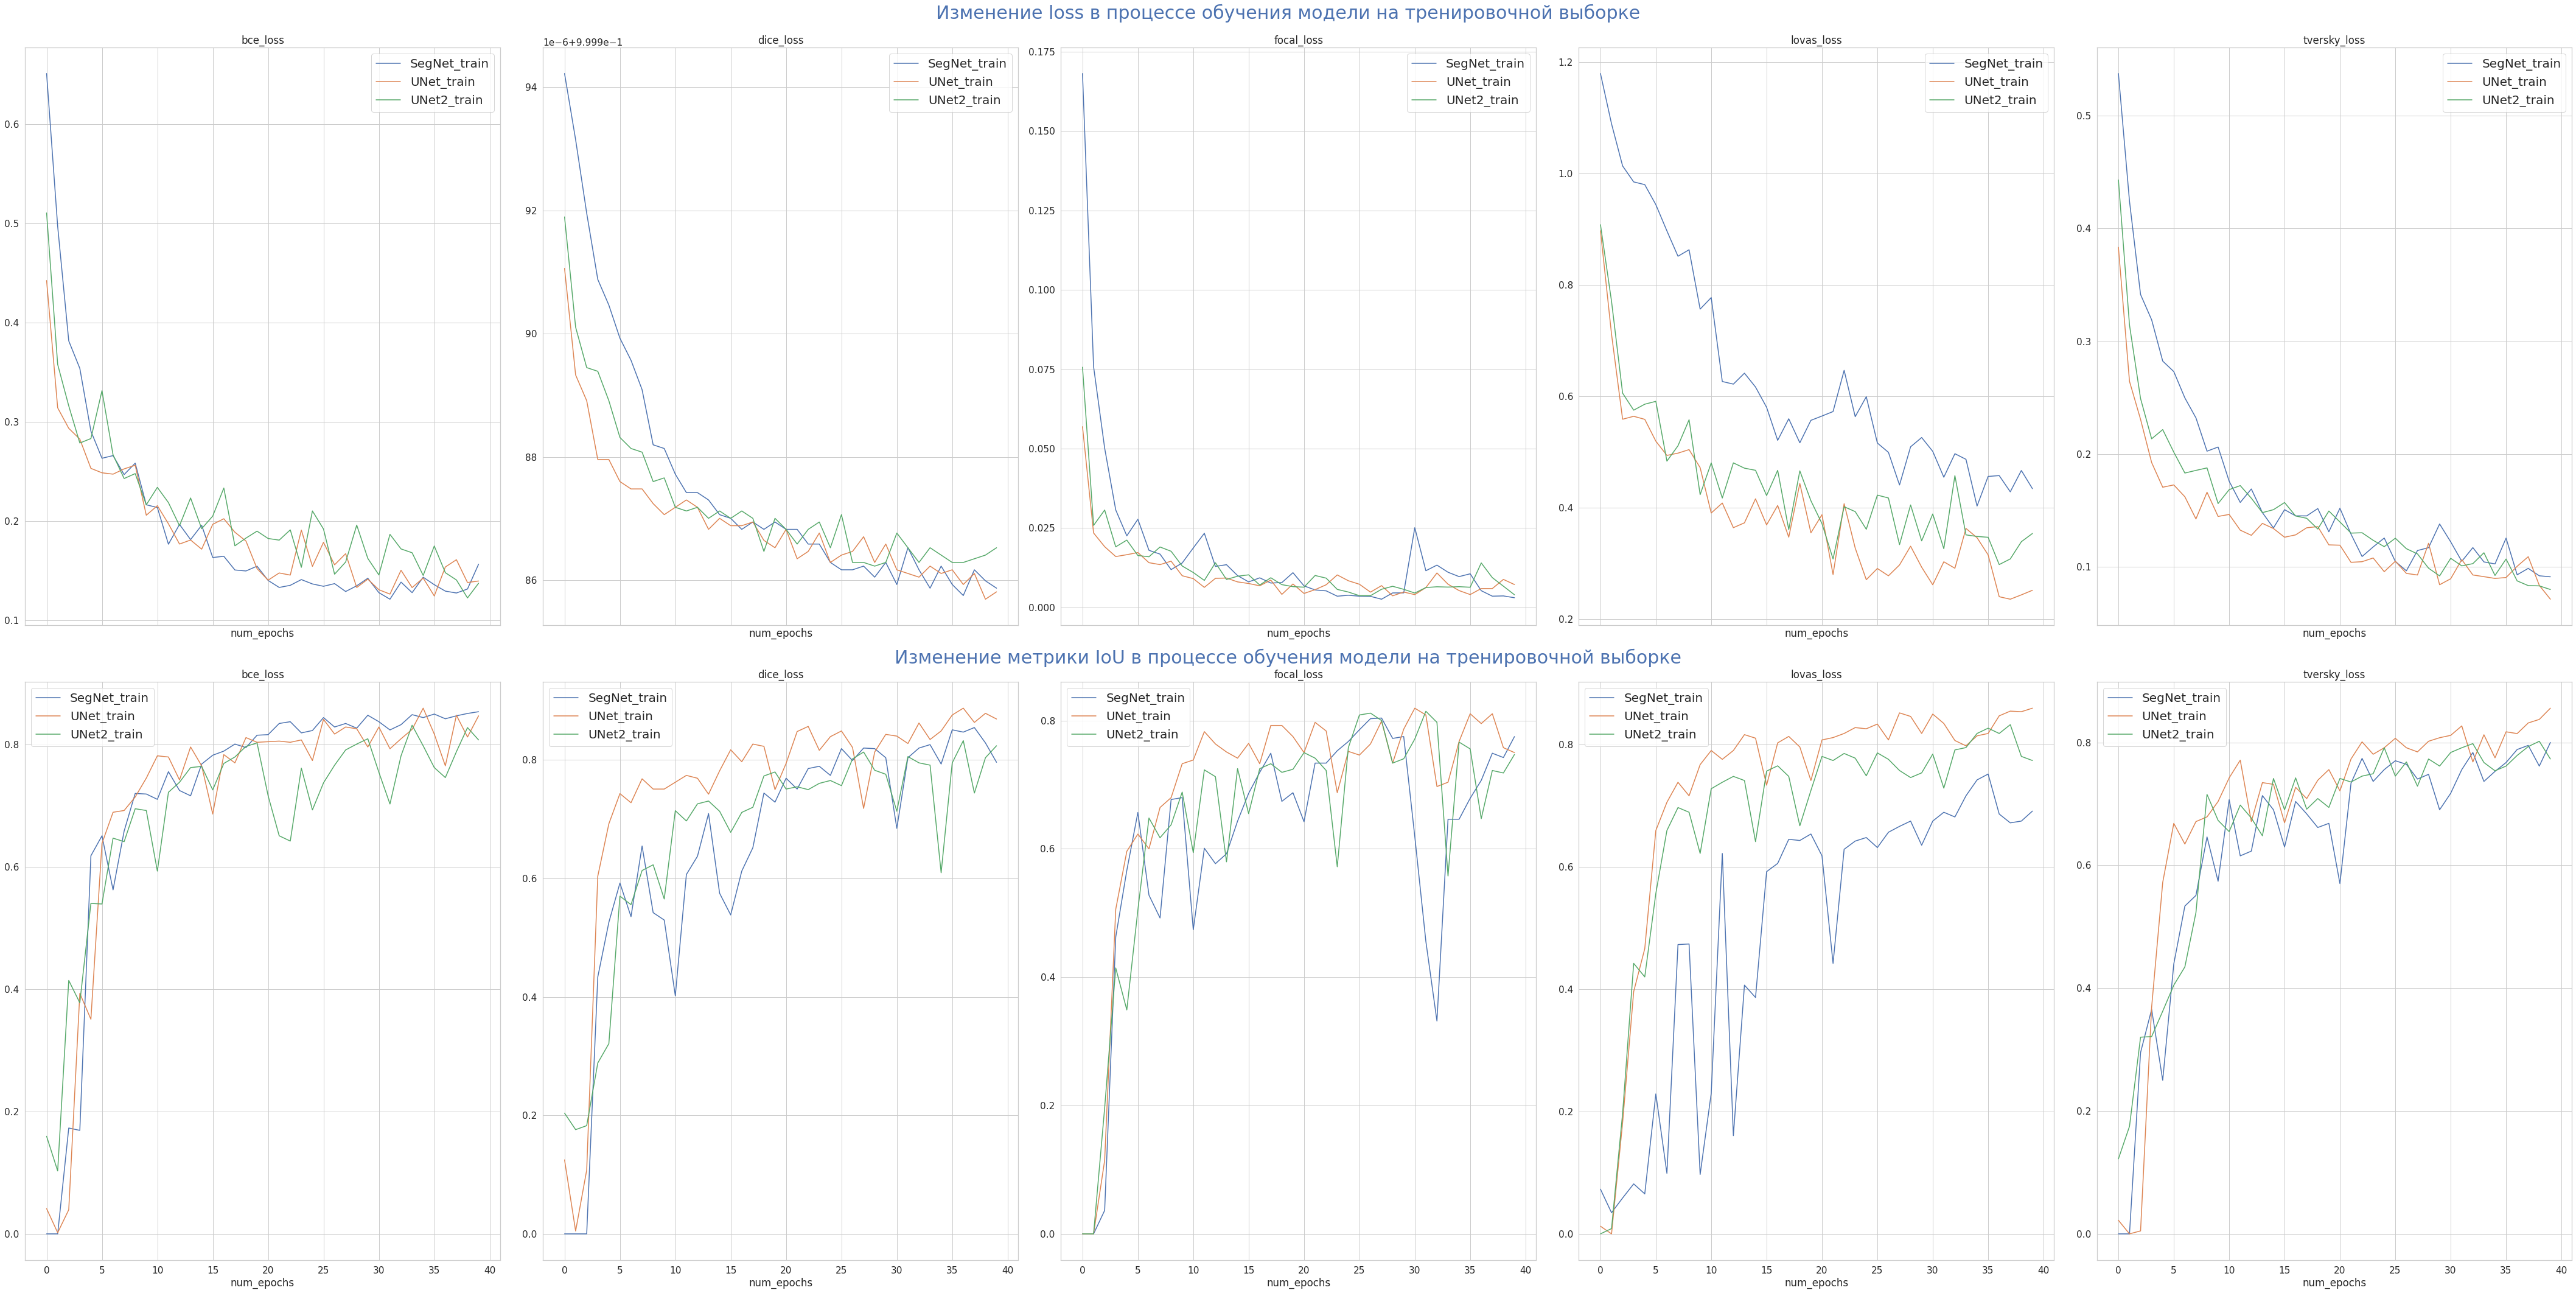

In [ ]:
fig, axes = plt.subplots(2,len(res_dict['losses']), figsize = (60, 30), sharex = True)
plt.figtext(0.5,1, "Изменение loss в процессе обучения модели на тренировочной выборке", ha="center", va="top", fontsize=30, color="b")
plt.figtext(0.5,0.51, "Изменение метрики IoU в процессе обучения модели на тренировочной выборке", ha="center", va="top", fontsize=30, color="b")
i = -1
for k1, v1 in res_dict.items(): # k1 - losses or scores
    i += 1
    j = 0
    for k2, v2 in v1.items():
        for k3, v3 in v2.items():# k2 - type of loss
            
            axes[i,j].plot(v3['train'], label = k3 + '_train') # v2.keys() - model_name      
        axes[i,j].set_xlabel('num_epochs')
        axes[i,j].set_title(k2)
        axes[i,j].legend(loc="best", fontsize=20)
        j += 1  
        
        
            
fig.tight_layout(pad=3, w_pad=1, h_pad=3.0)
            
plt.show()

## Изменение loss и метрики IoU для каждой функции потери в процессе обучения модели на валидационной выборке 

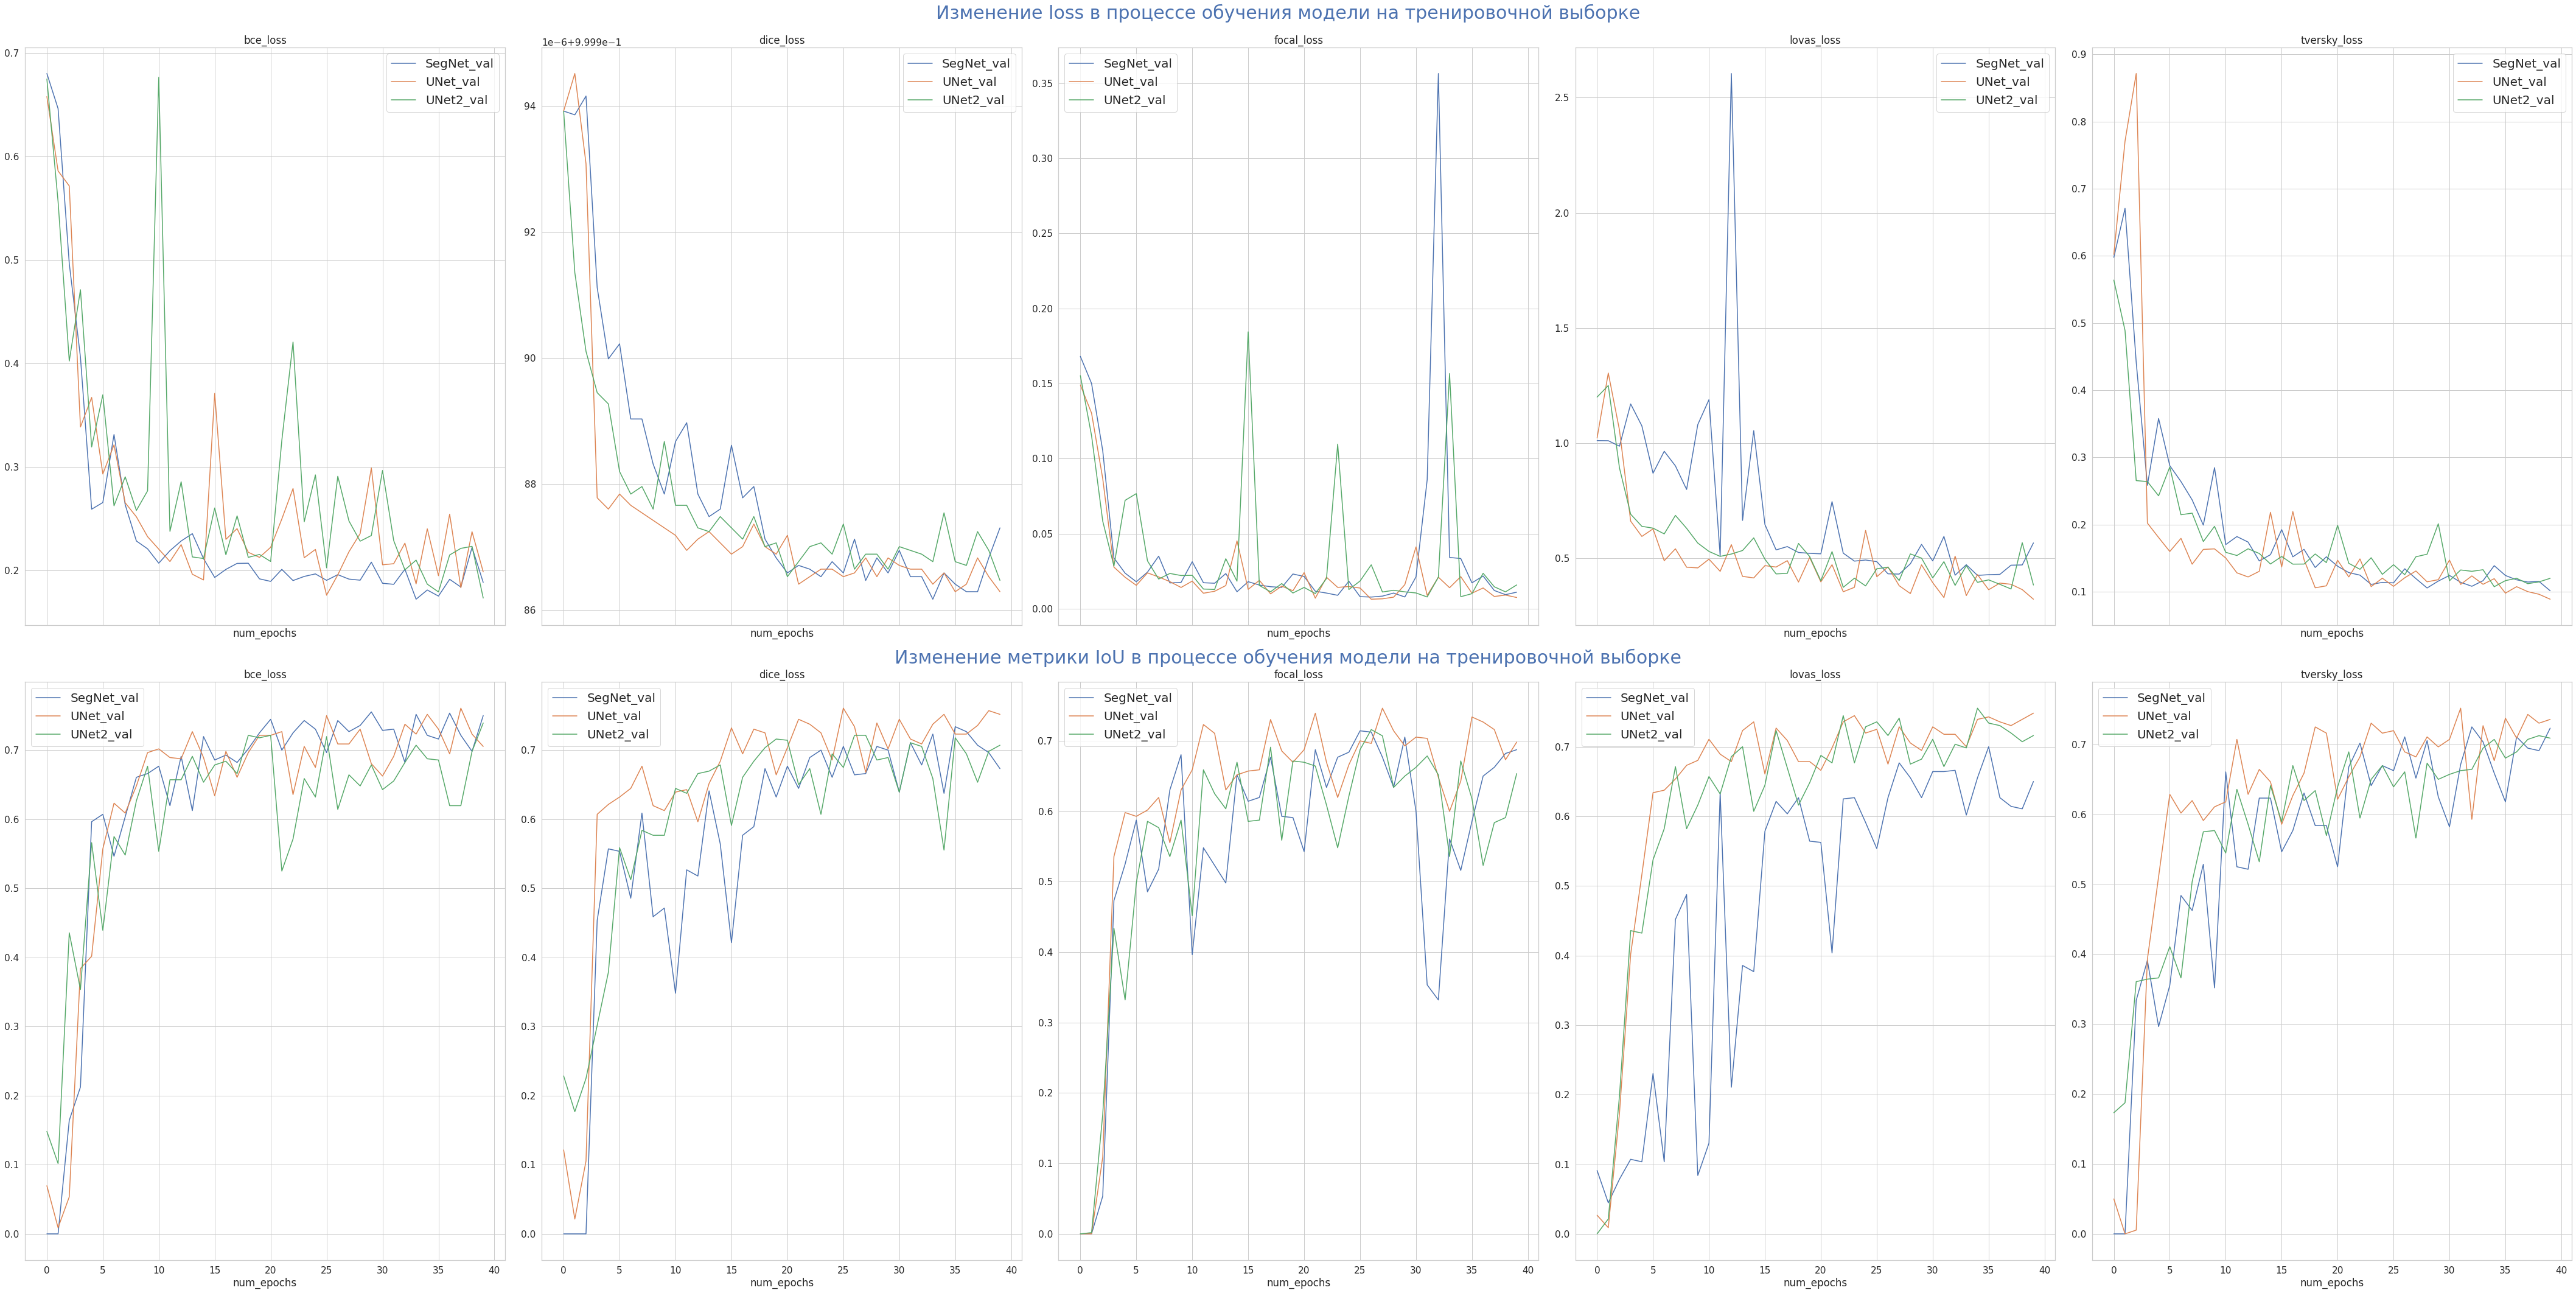

In [ ]:
fig, axes = plt.subplots(2,len(res_dict['losses']), figsize = (60, 30), sharex = True)
plt.figtext(0.5,1, "Изменение loss в процессе обучения модели на тренировочной выборке", ha="center", va="top", fontsize=30, color="b")
plt.figtext(0.5,0.51, "Изменение метрики IoU в процессе обучения модели на тренировочной выборке", ha="center", va="top", fontsize=30, color="b")
i = -1
for k1, v1 in res_dict.items(): # k1 - losses or scores
    i += 1
    j = 0
    for k2, v2 in v1.items():
        for k3, v3 in v2.items():# k2 - type of loss
            
            axes[i,j].plot(v3['val'], label = k3 + '_val') # v2.keys() - model_name      
        axes[i,j].set_xlabel('num_epochs')
        axes[i,j].set_title(k2)
        axes[i,j].legend(loc="best", fontsize=20)
        j += 1  
        
        
            
fig.tight_layout(pad=3, w_pad=1, h_pad=3.0)
            
plt.show()

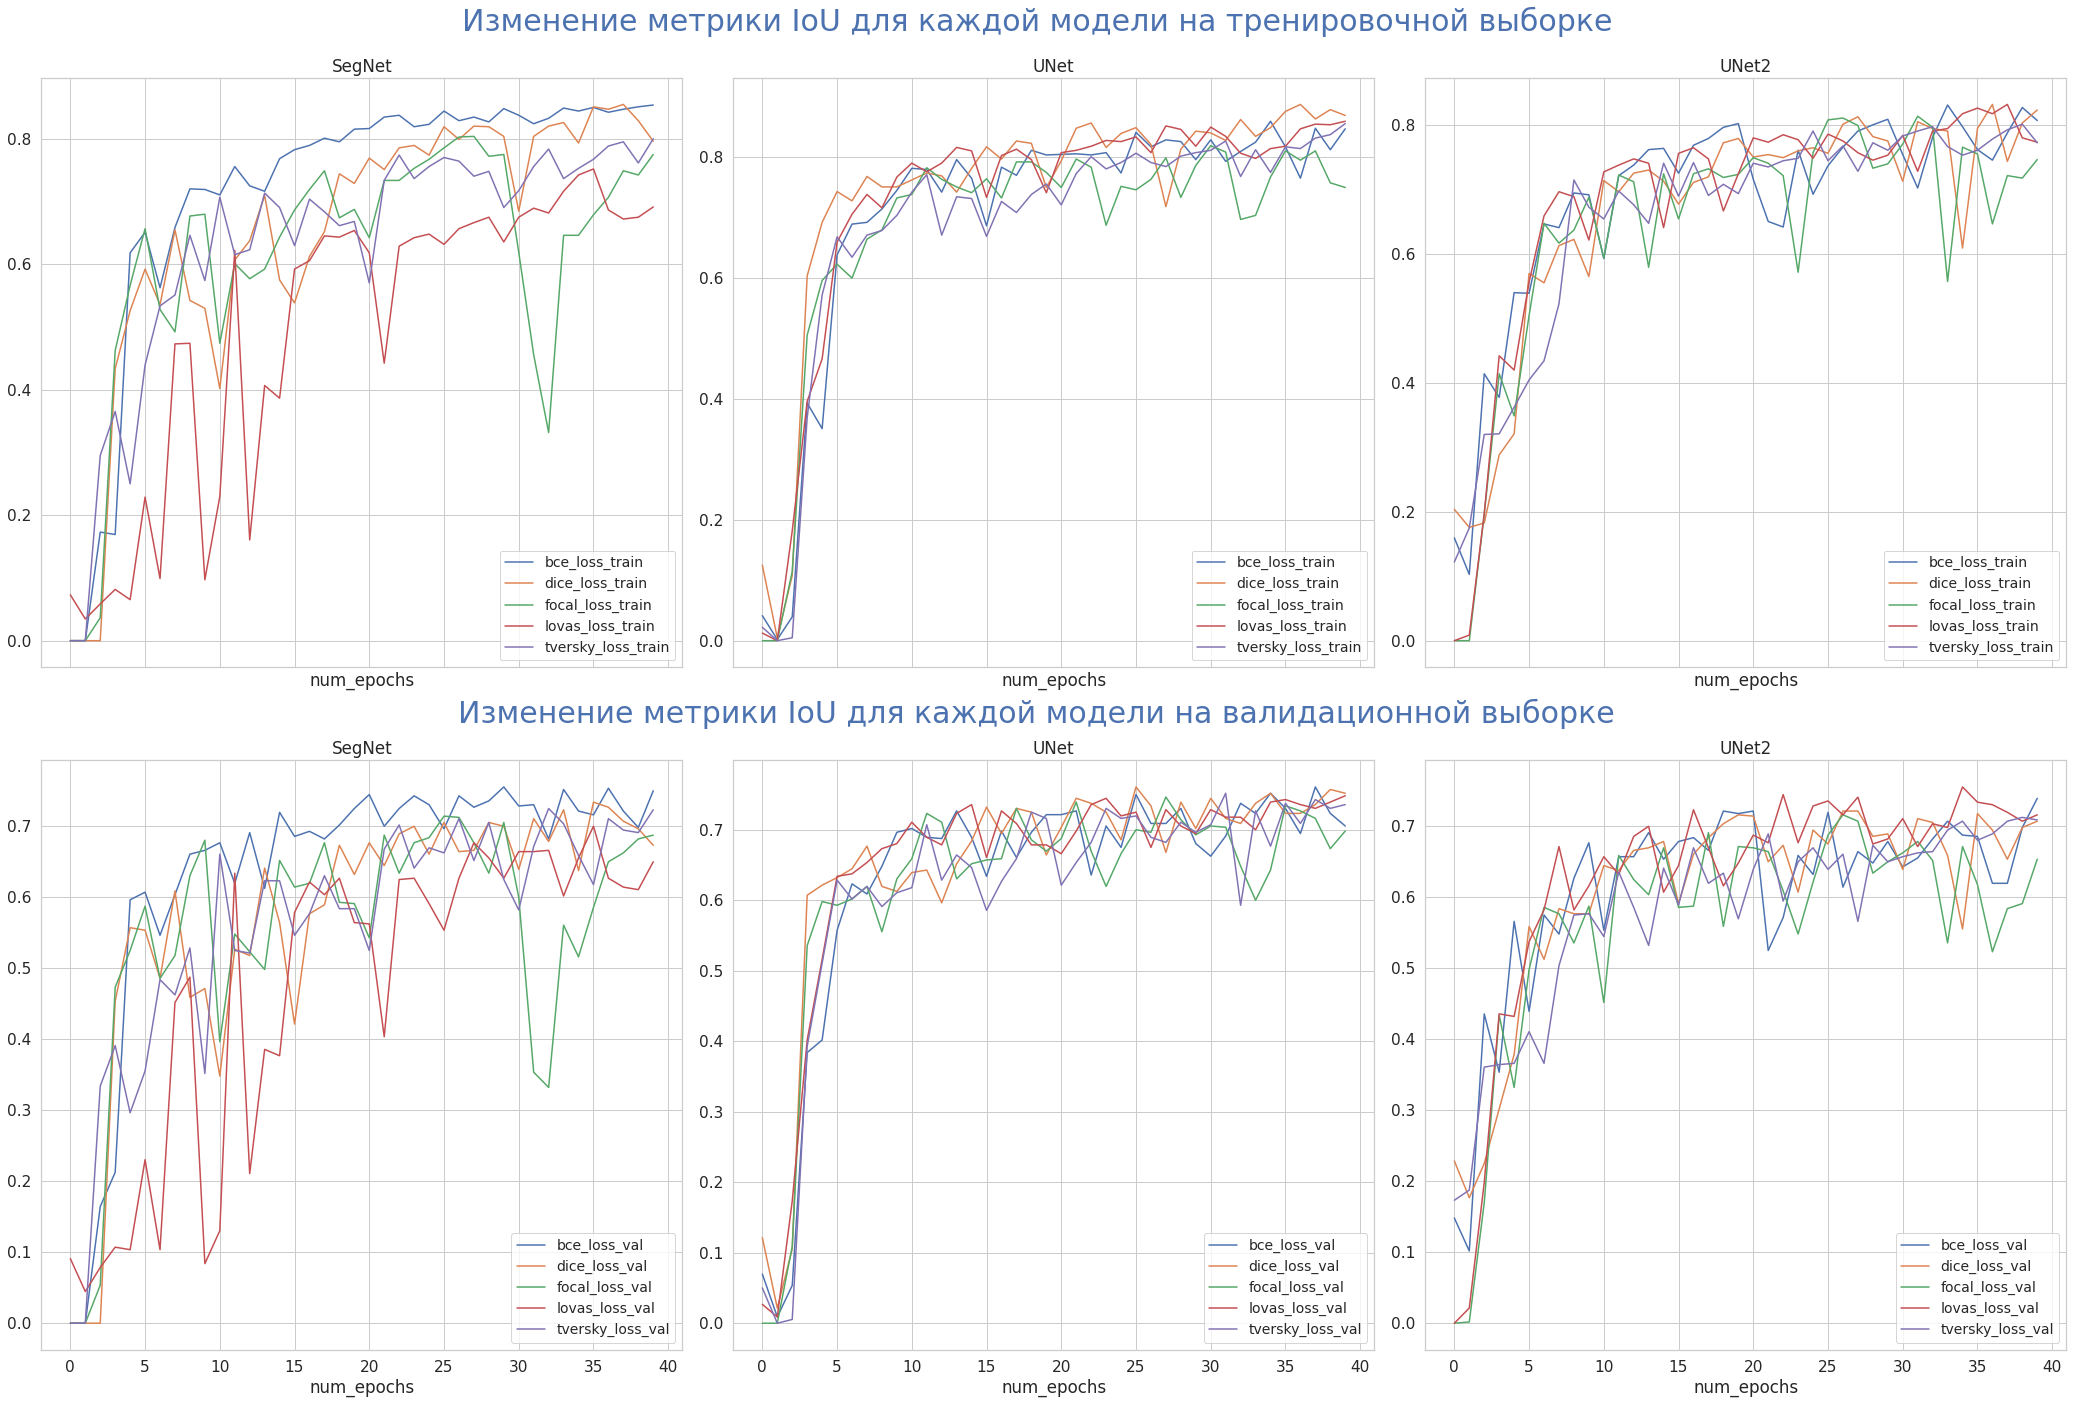

In [ ]:
res_model = {}
for k1,v1 in res_dict['scores'].items():
  for k2,v2 in v1.items():
    if k2 in res_model:
      res_model[k2].update({k1 : v2})
    else:
      res_model[k2] = {k1 : v2}

fig, axes = plt.subplots(2,3, figsize = (30, 20), sharex = True)
plt.figtext(0.5,1, "Изменение метрики IoU для каждой модели на тренировочной выборке", ha="center", va="top", fontsize=30, color="b")
plt.figtext(0.5,0.52, "Изменение метрики IoU для каждой модели на валидационной выборке", ha="center", va="top", fontsize=30, color="b")
i = -1
for k1, v1 in res_model.items(): # k1 - losses or scores
    i += 1
    for k2, v2 in v1.items():
    
        axes[0,i].plot(v2['train'], label = k2 + '_train')
        axes[1,i].plot(v2['val'], label = k2 + '_val') # v2.keys() - model_name      
        axes[0,i].set_xlabel('num_epochs')
        axes[0,i].set_title(k1)
        axes[1,i].set_xlabel('num_epochs')
        axes[1,i].set_title(k1)
        axes[0,i].legend(loc="best", fontsize=14)
        axes[1,i].legend(loc="best", fontsize=14)
 #       axes[0,i].set_ylim(bottom=0.5, top=0.9)
  #      axes[1,i].set_ylim(bottom=0.5, top=0.9)

 
        
        
            
fig.tight_layout(pad=3, w_pad=1, h_pad=3.0)
            
plt.show()

In [ ]:
import pandas as pd
pd.Series(test_score).sort_values()

unet_focal        0.646429
segnet_dice       0.651786
segnet_lovas      0.676786
unet2_focal       0.717857
unet2_lovas       0.719643
unet2_tversky     0.725000
segnet_focal      0.732143
unet2_bce         0.741071
unet2_dice        0.751786
segnet_tversky    0.762500
segnet_bce        0.764286
unet_bce          0.764286
unet_tversky      0.776786
unet_lovas        0.778571
unet_dice         0.780357
dtype: float64

### Наилучшие результаты получились у модели UNet №1, для каждой функции потери данная модель дает лучшие результаты. Наилучшее качество и стабильность модели  UNet №1 получается в комбинации с функция потерь dice_loss и lovas_loss. Эти результаты подтверждаются при сравнении метрики IoU на тестовой выборке. 
### Стоит отметить, что при обучении модель ведет себя не стабильно, и лучших результатов вероятно можно добиться увеличив время обучения и снизив learning rate.